In [1]:
# Import all the important stuff
import numpy as np
from scipy.optimize import minimize
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg

import emcee

# Personal python module for masks and profiles (available on github)
import gilphot as gp 

# MRF (Surface brightness contrast)
from mrf import sbcontrast

import timeit

In [2]:
# Defining all important galaxy-specific variables

gal = "5907"

pix_size = 2.5 # arcsec

ra, dec = 228.974042, 56.328771       # From NED
center_sub = (2000.3202, 2000.0745)   # from Imfit model (avg. of r and g)         
PA = 155.4248                         # from Imfit model

zerop_g = 27.31250651703545 
zerop_r = 26.97567074201916

# Galactic extinction (Schlafly et al. 2011; accesSWd via NED)
extinct_g = 0.035
extinct_r = 0.024

# Mean distance tabulated by NED (mostly Tully-Fisher distances)
# Angular to distance scale form arcsec2parsec.joseonorbe.com
dist = 14.275 # Mpc
DM = 30.73
kpc_factor = 0.06898588181927544 # kpc/100 arcsec

## Loading images

In [3]:
# "_sub": source-subtracted images processed with MRF

fitsfile_sub = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-final-g.fits"
image_g_sub = fits.getdata(fitsfile_sub)
print(np.shape(image_g_sub))

fitsfile_sub = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-final-r.fits"
image_r_sub = fits.getdata(fitsfile_sub)
print(np.shape(image_r_sub))

(4000, 4000)
(4000, 4000)


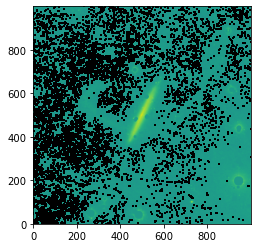

In [4]:
plt.imshow(np.log10(image_r_sub+5)[1500:2500, 1500:2500], origin="lower"); plt.show()

## Loading mask

"mask": default mask of MRF residuals, reduction artifacts, bright stars, other galaxies, cirrus, sources not deblended from central galaxy

"mask2": more aggressively masks bright stars and cirrus

In [5]:
maskfile = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask-cirrus.fits"

# If mask needs to be regenerated:
#mask = gp.make_source_mask( image_g_sub, image_r_sub, header_g_sub, regions, maskfile, expand = 0 )

mask, header_mask = fits.getdata(maskfile, header=True)
print( np.shape(mask) )

# If mask needs to be augmented for better limiting PA/ellip of 2D profile:
# regions = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_asymm.txt"
# mask = gp.update_source_mask( mask, header_mask, extra_regions_0, maskfile )
# fits.writeto(...)

(4000, 4000)


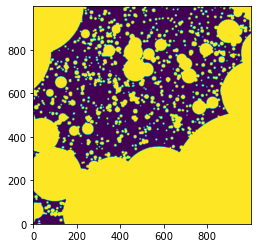

In [6]:
plt.imshow(mask[1500:2500, 1500:2500], origin="lower"); plt.show()

In [7]:
# Augment mask (mask out other galaxies)

regions2 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_asymm.txt"
maskfile2 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask-asymm.fits"
#mask_asymm = gp.update_source_mask(mask, header_mask, regions2, maskfile2)
mask_asymm = fits.getdata(maskfile2)

regions3 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_mask2.txt"
maskfile3 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask2.fits"
#mask2 = gp.update_source_mask(mask, header_mask, regions3, maskfile3)
mask2 = fits.getdata(maskfile3)

regions4 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_asymm.txt"
maskfile4 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask2-asymm.fits"
#mask2_asymm = gp.update_source_mask(mask2, header_mask, regions4, maskfile4)
mask2_asymm = fits.getdata(maskfile4)

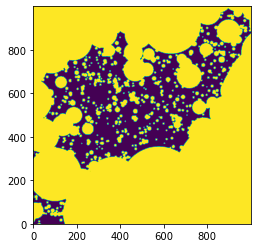

In [8]:
plt.imshow(mask2[1500:2500, 1500:2500], origin="lower"); plt.show()

## Surface brightness contrast

Function for estimating surface brightness as a function of angular scale bundled with MRF release. See Appendix B of MRF paper (van Dokkum et al. 2020, V1: https://arxiv.org/abs/1910.12867v1) for a description of the algorithm.

Warning: long run-time! 

In [9]:
blep = sbcontrast.cal_sbcontrast(image_g_sub, mask, 2.5, zerop_g, scale_arcsec=None, sigma=3.0)

blep = sbcontrast.cal_sbcontrast(image_r_sub, mask, 2.5, zerop_r, scale_arcsec=None, sigma=3.0)

    - 3.0-sigma surface brightness limit on 5 arcsec scale is 27.9611 +- 0.0013
    - 3.0-sigma surface brightness limit on 10 arcsec scale is 28.5231 +- 0.0029
    - 3.0-sigma surface brightness limit on 20 arcsec scale is 29.1257 +- 0.0072
    - 3.0-sigma surface brightness limit on 60 arcsec scale is 29.9724 +- 0.0419
    - 3.0-sigma surface brightness limit on 120 arcsec scale is 30.1841 +- 0.1767
    - 3.0-sigma surface brightness limit on 240 arcsec scale is nan +- inf
    - 3.0-sigma surface brightness limit on 300 arcsec scale is nan +- inf
    - 3.0-sigma surface brightness limit on 5 arcsec scale is 27.5482 +- 0.0013
    - 3.0-sigma surface brightness limit on 10 arcsec scale is 28.1006 +- 0.0029
    - 3.0-sigma surface brightness limit on 20 arcsec scale is 28.6731 +- 0.0072
    - 3.0-sigma surface brightness limit on 60 arcsec scale is 29.4549 +- 0.0419
    - 3.0-sigma surface brightness limit on 120 arcsec scale is 29.6225 +- 0.1767
    - 3.0-sigma surface brightness limit

## Measuring sky background

Measuring sky background in circular annuli surrounding the galaxy. The minimum radius searched is typically at or slightly beyond the outmost low SB emission potentially associated with the galaxy (when inspecting the source-subtracted image in extreme stretch). The maximum radius searches is (typically) four times the minimum radius. The radial bin width is selected so that there are approximately 20 bins. 

(Random) sky error includes uncertainty on final sky value stemming from distribution of pixel values inside the selected radial bin. Systematic sky error is taken to be the standard deviation of all sky values sampled within the sky annulus. In general in this notebook, random error is shown as error bars on points, and additional systematic uncertainty is shown as a shaded error envelope.

For now, the sky background across the entire r- and g-band images is measured (hence "global"). Later, the sky measurement will be divided into quadrants to attempt to counteract any large scale variation across the image (due to deviations from flatness in reduction or differing contamination from cirrus, for instance). The sky is measured first with "mask" and then with "mask2".

Selecting r-band sky based on first sufficiently flat local slope:


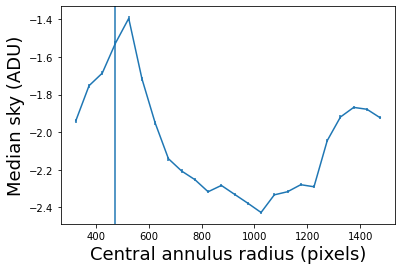

Selecting g-band sky based on first sufficiently flat local slope:


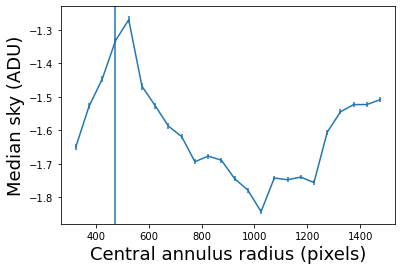

In [9]:
new_mask = mask_asymm

print("Selecting r-band sky based on first sufficiently flat local slope:")    
skies, errs, best_i, slopes, scores, radii = gp.find_best_sky(image_r_sub, rad1=300, rad2=1500, initial_mask=new_mask, center=center_sub, width=50, step=50, baseline=3, fulloutput=True, method="thresh_slope", thresh=1.5e-3)
gp.plot_skies(skies, errs, radii, best_i)

r_sky_global= skies[best_i]
r_sky_err_global = errs[best_i]
r_sky_err_sys_global = np.nanstd(skies)

print("Selecting g-band sky based on first sufficiently flat local slope:")    
skies, errs, best_i, slopes, scores, radii = gp.find_best_sky(image_g_sub, rad1=300, rad2=1500, initial_mask=new_mask, center=center_sub, width=50, step=50, baseline=3, fulloutput=True, method="thresh_slope", thresh=1.5e-3)
gp.plot_skies(skies, errs, radii, best_i)

g_sky_global= skies[best_i]
g_sky_err_global = errs[best_i]
g_sky_err_sys_global = np.nanstd(skies)

Selecting r-band sky based on first sufficiently flat local slope:


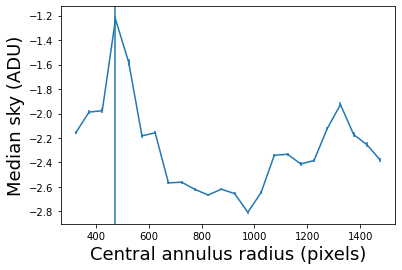

Selecting g-band sky based on first sufficiently flat local slope:


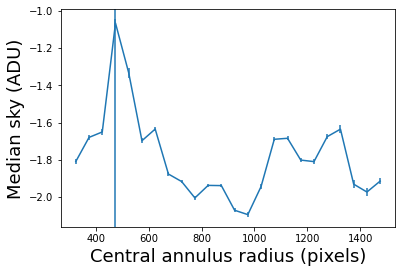

In [10]:
new_mask = mask2_asymm

print("Selecting r-band sky based on first sufficiently flat local slope:")    
skies, errs, best_i, slopes, scores, radii = gp.find_best_sky(image_r_sub, rad1=300, rad2=1500, initial_mask=new_mask, center=center_sub, width=50, step=50, baseline=3, fulloutput=True, method="thresh_slope", thresh=1.5e-3)
gp.plot_skies(skies, errs, radii, best_i)

r_sky2_global= skies[best_i]
r_sky2_err_global = errs[best_i]
r_sky2_err_sys_global = np.nanstd(skies)

print("Selecting g-band sky based on first sufficiently flat local slope:")    
skies, errs, best_i, slopes, scores, radii = gp.find_best_sky(image_g_sub, rad1=300, rad2=1500, initial_mask=new_mask, center=center_sub, width=50, step=50, baseline=3, fulloutput=True, method="thresh_slope", thresh=1.5e-3)
gp.plot_skies(skies, errs, radii, best_i)

g_sky2_global= skies[best_i]
g_sky2_err_global = errs[best_i]
g_sky2_err_sys_global = np.nanstd(skies)

## Azimuthally averaged profiles

photutils.isophote (https://photutils.readthedocs.io/en/stable/isophote.html) provides similar functionality to IRAF's ellipse. Elliptical isophotes are fitted to the r-band image and then imposed on the g-band, to ensure that the area probed by the two profiles is consistent. A fair amount of tweaking of starting parameters was generally needed to arrive at a well-behaved isophotal solution (ie. with few or no discontinuities in position angle and ellipticity). The bilinear integration mode was found to have almost identical results to the much slower mean or median integration modes. 

As with the sky measurements, profile fitting is first done for "mask" and then separately for "mask2". 

In [11]:
# Import all things needed for photutils profiles

from photutils.isophote import Ellipse, EllipseGeometry

In [12]:
# Need to supply Ellipse with masked arrays

mask_ma = np.ma.masked_where( mask > 0, mask )

image_r_masked = np.ma.masked_array(image_r_sub, mask_ma.mask)
image_g_masked = np.ma.masked_array(image_g_sub, mask_ma.mask)

# Additional mask for stellar stream (to prevent influence on contour shape/orientation)
mask_ma2 = np.ma.masked_where( mask_asymm > 0, mask_asymm )

image_r_masked_asymm = np.ma.masked_array(image_r_sub, mask_ma2.mask)
image_g_masked_asymm = np.ma.masked_array(image_g_sub, mask_ma2.mask)

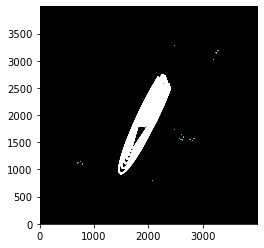

In [13]:
# Ellipse parameters for the first guess
x0 = center_sub[1]    # center position
y0 = center_sub[0]    # center position
sma = 100            # semimajor axis length in pixels
eps = 0.85          # ellipticity
pa = 64 / 180. * np.pi

g = EllipseGeometry(x0, y0, sma, eps, pa)

ellipse_gal = Ellipse(image_r_masked_asymm, geometry=g)

# Running the fit!
isophotes_r0 = ellipse_gal.fit_image(integrmode='bilinear', step=0.1, sclip=3., nclip=2, fflag=0.7, maxsma=1200, fix_center=True)
isophotes_r = gp.impose_isophotes(image_r_masked, isophotes_r0, central_isophote=True)
gp.plot_isophotes(image_r_sub, isophotes_r)

isophotes_g_fixed = gp.impose_isophotes(image_g_masked, isophotes_r, central_isophote=True)

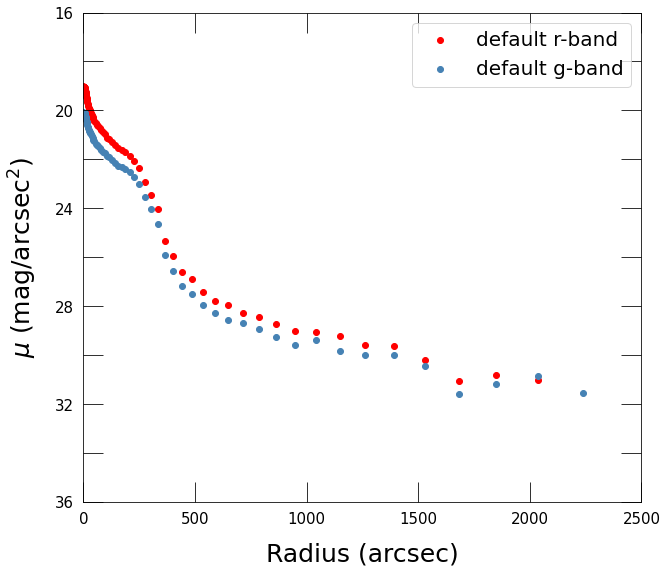

In [14]:
# Quick sanity check: how do the profiles look?
# Called "default" profiles because further refinements are coming

fig, ax = plt.subplots()

plt.scatter(isophotes_r.sma*pix_size, gp.flux_to_mags(isophotes_r.intens, r_sky_global, zerop_r), color="r", label="default r-band")
plt.scatter(isophotes_g_fixed.sma*pix_size, gp.flux_to_mags(isophotes_g_fixed.intens, g_sky_global, zerop_g), color="steelblue", label="default g-band")
plt.gca().invert_yaxis()

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

ax.set_xlim(0, 2500)
ax.set_ylim(36, 16)

plt.legend(prop={'size': 20})

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36" ])

fig.set_size_inches(10, 9)

plt.show()

0.8542177036064447


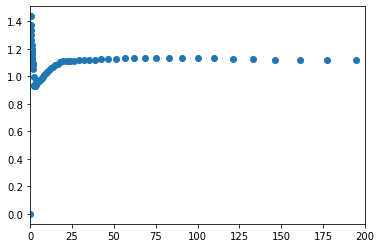

In [15]:
# Quick plots to look at isophote parameters
# Very helpful when tuning starting parameters for fit

print(isophotes_r.eps[-1])

plt.scatter(isophotes_r.sma, isophotes_r.pa)

plt.xlim([0,200])
#plt.ylim([450,550])
plt.show()

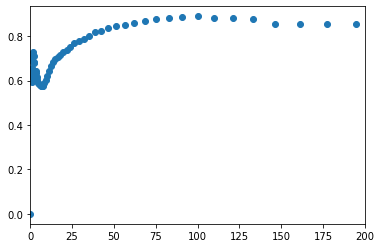

In [16]:
plt.scatter(isophotes_r.sma, isophotes_r.eps)

plt.xlim([0,200])
#plt.ylim([450,550])
plt.show()

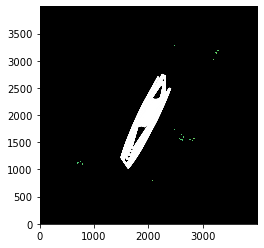

In [17]:
mask_ma = np.ma.masked_where( mask2 > 0, mask2 )

image_r_masked = np.ma.masked_array(image_r_sub, mask_ma.mask)
image_g_masked = np.ma.masked_array(image_g_sub, mask_ma.mask)

# Additional mask for stellar stream (to prevent influence on contour shape/orientation)
mask_ma2 = np.ma.masked_where( mask2_asymm > 0, mask2_asymm )

image_r_masked_asymm = np.ma.masked_array(image_r_sub, mask_ma2.mask)
image_g_masked_asymm = np.ma.masked_array(image_g_sub, mask_ma2.mask)

# Ellipse parameters for the first guess
x0 = center_sub[1]    # center position
y0 = center_sub[0]    # center position
sma = 100            # semimajor axis length in pixels
eps = 0.85          # ellipticity
pa = 64 / 180. * np.pi

g = EllipseGeometry(x0, y0, sma, eps, pa)

ellipse_gal = Ellipse(image_r_masked_asymm, geometry=g)

# Running the fit!
isophotes_r0 = ellipse_gal.fit_image(integrmode='bilinear', step=0.1, sclip=3., nclip=2, fflag=0.7, maxsma=1200, fix_center=True)
isophotes_r2 = gp.impose_isophotes(image_r_masked, isophotes_r0, central_isophote=True)
gp.plot_isophotes(image_r_sub, isophotes_r2)

isophotes_g2_fixed = gp.impose_isophotes(image_g_masked, isophotes_r2, central_isophote=True)

### Azimuthally averaged profiles by quadrant

The previous isophotes fitted to the r-band image (with "mask" or "mask2") are now re-applied with an additional quadrant mask. This is all handled inside the QuadrantProfiles class. Note that the quadrant boundaries are defined along major and minor axes. Assuming a symmetrical galaxy and a properly identified center & position angle, each quadrant profile samples equivalent regions of the galaxy and the resulting profiles should be similar.

The purpose of adopting quadrant profiles is to better handle large-scale variations in the sky/background/cirrus. For very deep profiles, even a small change in the local sky can have a big impact.

Quadrant and source mask for quad 0:


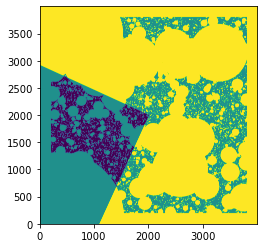

Quadrant and source mask for quad 1:


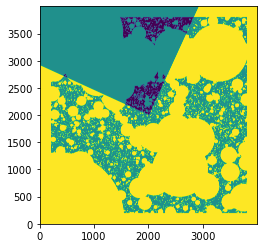

Quadrant and source mask for quad 2:


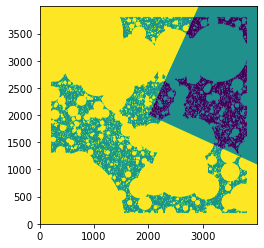

Quadrant and source mask for quad 3:


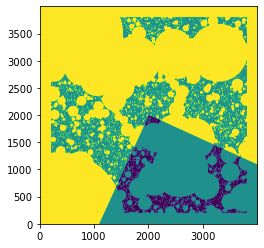

Quadrant and source mask for quad 0:


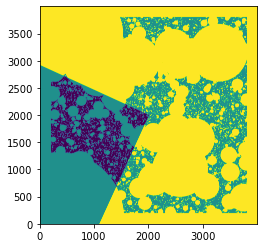

Quadrant and source mask for quad 1:


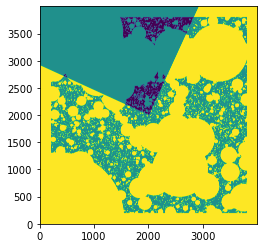

Quadrant and source mask for quad 2:


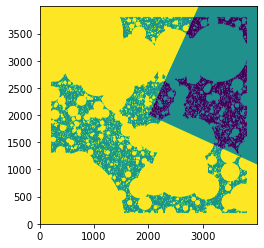

Quadrant and source mask for quad 3:


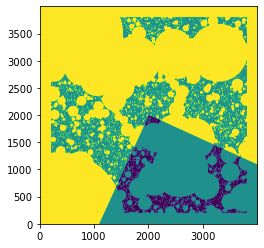

Quadrant and source mask for quad 0:


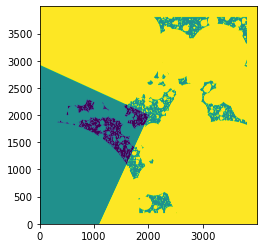

Quadrant and source mask for quad 1:


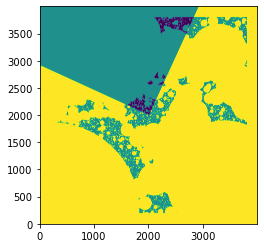

Quadrant and source mask for quad 2:


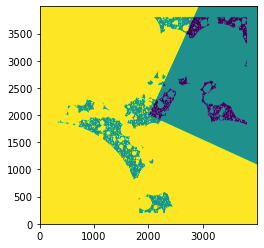

Quadrant and source mask for quad 3:


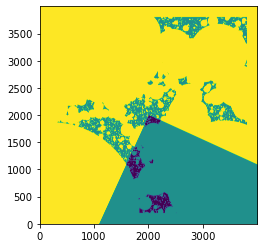

Quadrant and source mask for quad 0:


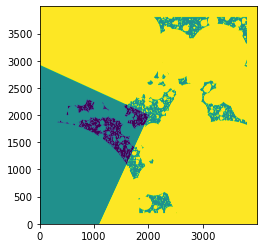

Quadrant and source mask for quad 1:


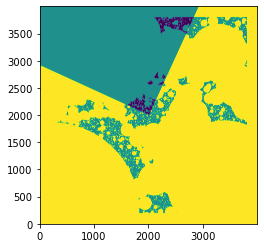

Quadrant and source mask for quad 2:


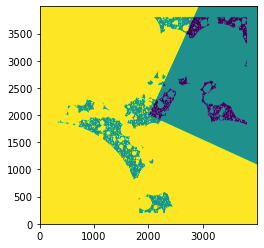

Quadrant and source mask for quad 3:


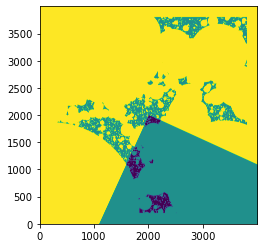

In [18]:
from gilphot import QuadrantProfiles

PA_0 = (270 - PA) * np.pi/180 
x0_2D = np.mean(isophotes_r.x0) 
y0_2D = np.mean(isophotes_r.y0)

quads_r = QuadrantProfiles(image_r_sub, mask, isophotes_r, (y0_2D, x0_2D), PA_0)
quads_g = QuadrantProfiles(image_g_sub, mask, isophotes_r, (y0_2D, x0_2D), PA_0)

quads_r2 = QuadrantProfiles(image_r_sub, mask2, isophotes_r2, (y0_2D, x0_2D), PA_0)
quads_g2 = QuadrantProfiles(image_g_sub, mask2, isophotes_r2, (y0_2D, x0_2D), PA_0)

Measuring sky for quadrant 0 ...


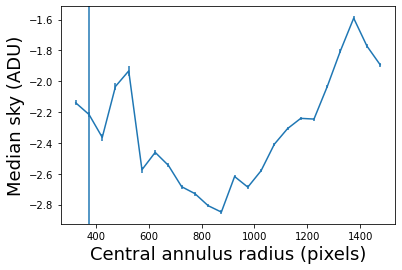

Measuring sky for quadrant 1 ...


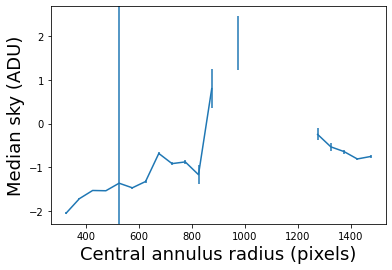

Measuring sky for quadrant 2 ...


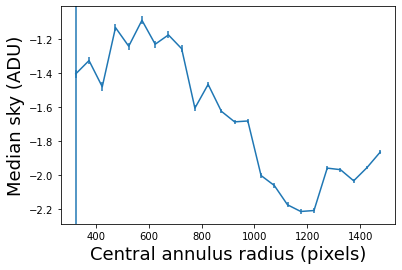

Measuring sky for quadrant 3 ...


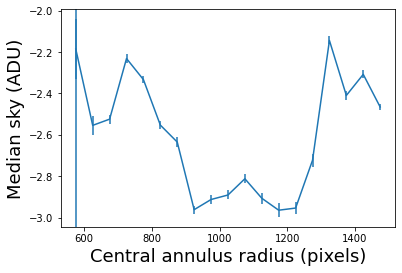

Measuring sky for quadrant 0 ...


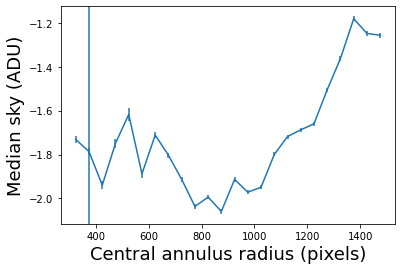

Measuring sky for quadrant 1 ...


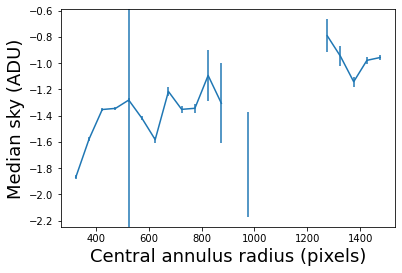

Measuring sky for quadrant 2 ...


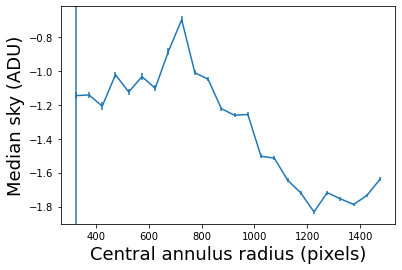

Measuring sky for quadrant 3 ...


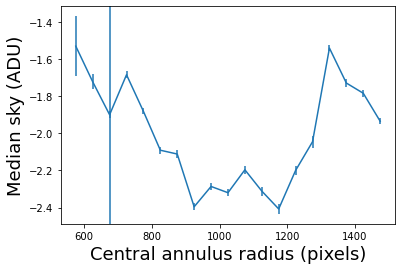

Measuring sky for quadrant 0 ...


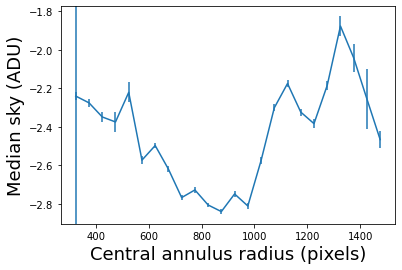

Measuring sky for quadrant 1 ...


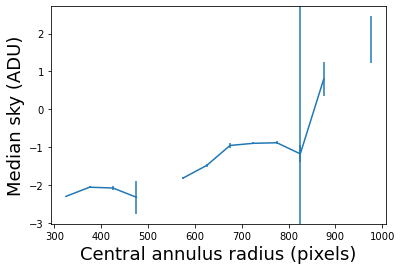

Measuring sky for quadrant 2 ...


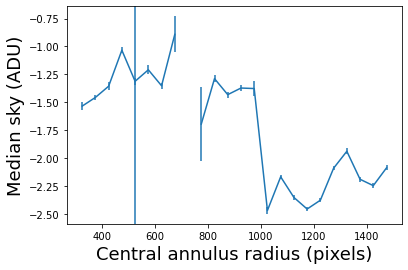

Measuring sky for quadrant 3 ...


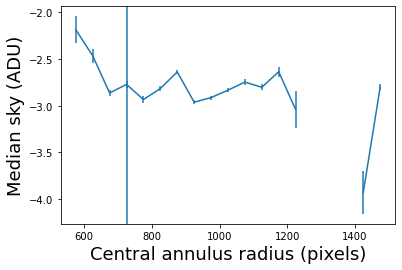

Measuring sky for quadrant 0 ...


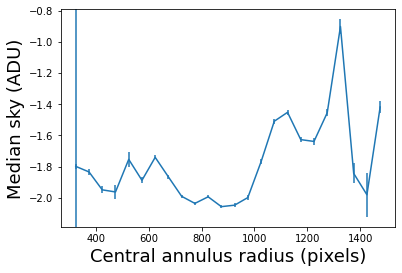

Measuring sky for quadrant 1 ...


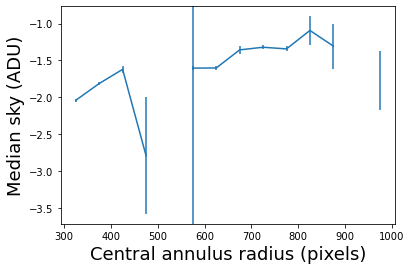

Measuring sky for quadrant 2 ...


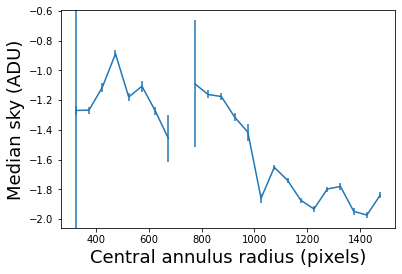

Measuring sky for quadrant 3 ...


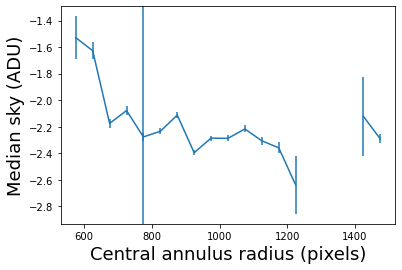

In [19]:
# Measuing sky within quadrants
# Same parameters used as for measurements of "global" sky

quads_r.measure_sky(image_r_sub, 300, 1500, bin_width=50, baseline=3, method="thresh_slope", thresh=1.5e-3, mask=mask_asymm)
quads_g.measure_sky(image_g_sub, 300, 1500, bin_width=50, baseline=3, method="thresh_slope", thresh=1.5e-3, mask=mask_asymm)

quads_r2.measure_sky(image_r_sub, 300, 1500, bin_width=50, baseline=3, method="thresh_slope", thresh=1.5e-3, mask=mask2_asymm)
quads_g2.measure_sky(image_g_sub, 300, 1500, bin_width=50, baseline=3, method="thresh_slope", thresh=1.5e-3, mask=mask2_asymm)


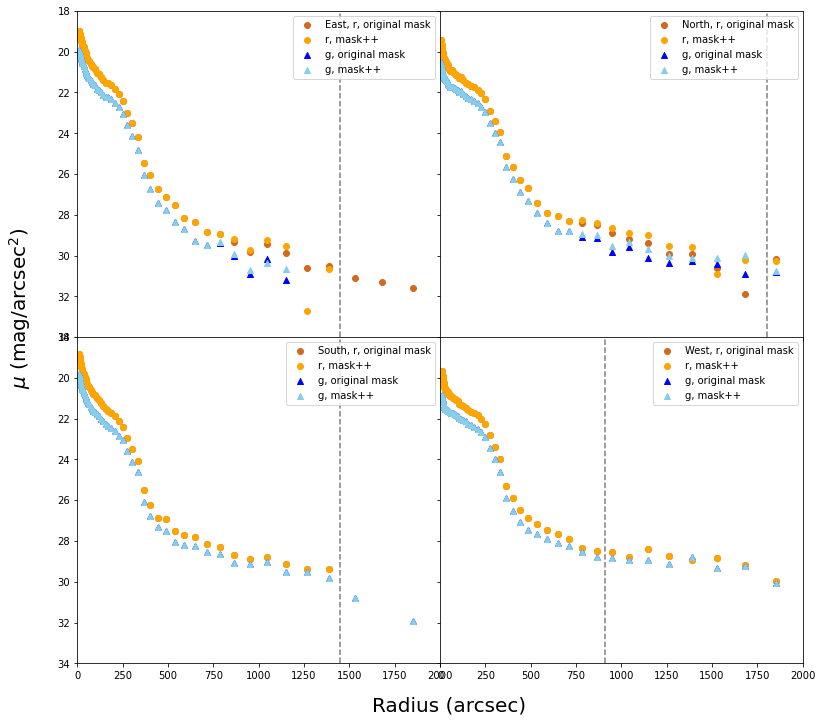

In [20]:
# Marking maximum reliable radius by comparing masked and aggressively masked profiles
# Want to reject where they start to differ (or where number of unmasked pixels is too low)

max_r = [1450, 1450, 1800, 910] # arcsec

fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

a = [ax[1,0], ax[0,0], ax[0,1], ax[1,1]]
qlabel = ["South", "East", "North", "West"]

for i in range(0,4):
    
    a[i].scatter(quads_r.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_r.quadIsophotes[i].intens, r_sky_global, zerop_r), label = f"{qlabel[i]}, r, original mask", color='chocolate')
    a[i].scatter(quads_r2.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_r2.quadIsophotes[i].intens, r_sky_global, zerop_r), label = "r, mask++", color='orange')
    a[i].scatter(quads_g.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_g.quadIsophotes[i].intens, g_sky_global, zerop_g), label = "g, original mask", color='b', marker='^')
    a[i].scatter(quads_g2.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_g2.quadIsophotes[i].intens, g_sky_global, zerop_g), label = "g, mask++", color='skyblue', marker='^')
    a[i].axvline(x=max_r[i], ls='--', color='k', alpha=0.5)
    
    a[i].set_xlim(0, 2000)
    a[i].set_ylim(34, 18)
    a[i].legend(loc=1)

ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
ax[1,1].set_yticklabels([])  

fig.text(0.44, 0.07, "Radius (arcsec)", size=20)
fig.text(0.05, 0.45, r"$\mu$ (mag/arcsec$^2$)", size=20, rotation=90)

fig.set_size_inches(13, 12)
plt.show()

In [21]:
quads_r.set_quad_limits(max_r)
quads_g.set_quad_limits(max_r)

quads_r2.set_quad_limits(max_r)
quads_g2.set_quad_limits(max_r)

In [22]:
# Generating r-band combined profile 
# (Using individual profiles, sky values, and max. radii for each quadrant)
r_skies = [r_sky_global, r_sky_err_global, r_sky_err_sys_global]

rad_r, SB_r, err_r_p, err_r_m, err_r_ps, err_r_ms = quads_r.combine_quad_profiles(isophotes_r, 
                                                                                  r_skies,  
                                                                                  zerop_r)

err_all_tmp = [SB_r - err_r_p, err_r_m - SB_r]
SB_err_r = np.array(err_all_tmp)


# Generating g-band combined profile
g_skies = [g_sky_global, g_sky_err_global, g_sky_err_sys_global]

rad_g, SB_g, err_g_p, err_g_m, err_g_ps, err_g_ms = quads_g.combine_quad_profiles(isophotes_g_fixed, 
                                                                                  g_skies,  
                                                                                  zerop_g)

err_all_tmp = [SB_g - err_g_p, err_g_m - SB_g]
SB_err_g = np.array(err_all_tmp)

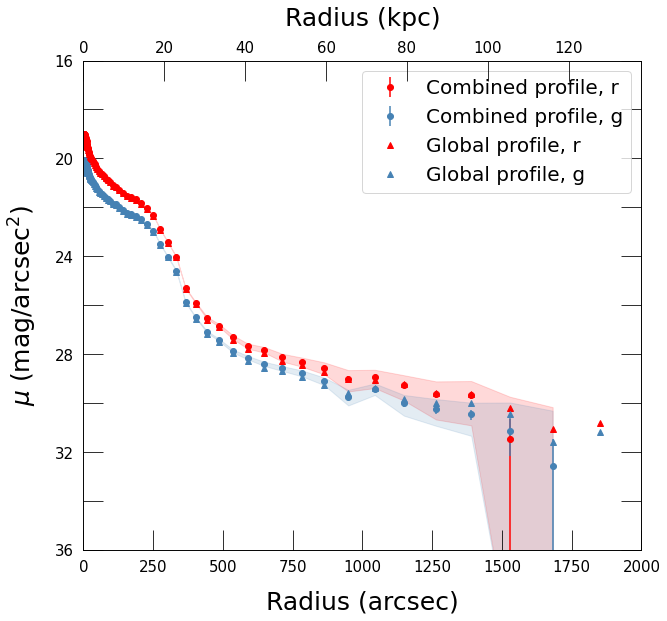

In [23]:
# Comparing combined profile with original profiles as produced by photutils.isophote.Ellipse

fig, ax = plt.subplots()

# Plotting combined profiles and their envelopes including systematic sky uncertainty
ax.errorbar(rad_r*pix_size, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="r", label="Combined profile, r", markersize=6)
ax.errorbar(rad_g*pix_size, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="steelblue", label="Combined profile, g", markersize=6)

plt.fill_between(rad_r*pix_size, err_r_ps - extinct_r, err_r_ms - extinct_r, alpha=0.15, color="r")
plt.fill_between(rad_g*pix_size, err_g_ps - extinct_g, err_g_ms - extinct_g, alpha=0.15, color="steelblue")

plt.errorbar(isophotes_r.sma*pix_size, 
             gp.flux_to_mags(isophotes_r.intens, r_sky_global, zerop_r), 
             fmt='^', 
             c="r", 
             label="Global profile, r")

plt.errorbar(isophotes_g_fixed.sma*pix_size, 
             gp.flux_to_mags(isophotes_g_fixed.intens, g_sky_global, zerop_g), 
             fmt='^', 
             c="steelblue", 
             label="Global profile, g")


leg = plt.legend(loc=1, prop={'size': 20})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*2000) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 2000)
ax.set_ylim(36, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36" ])

fig.set_size_inches(10,9)
plt.show()

## 2D modelling with Imfit

Procedure to follow outside of this notebook:
- Work with non source-subtracted cutout (sky counts important for sigma image)
- Pass gain, ncombine, and rdnoise estimates as arguments when fitting
- Start simple and add more (or more complicated) components
- Re-run final model on source-subtracted cutout (fit small pixel shift first)
- Fit on a small region but then produce final models with full cutout (to enable apples-to-apples profile extraction and comparisons)

To generate model images at full size:

../makeimage --output NGC4307_model_r_PSF.fits --refimage ../../MRF/NGC4307/Images/NGC4307-final-r.fits [--psf NGC_4307_psf_r.fits] bestfit_parameters_imfit_final_r.dat

../makeimage --output NGC4307_model_g_PSF.fits --refimage ../../MRF/NGC4307/Images/NGC4307-final-g.fits [--psf NGC_4307_psf_g.fits] bestfit_parameters_imfit_final_g.dat

In [24]:
# Load in model images
fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_r_PSF.fits"
image_r_model_PSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_r_model_PSF))

fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_r_noPSF.fits"
image_r_model_noPSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_r_model_noPSF))

fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_g_PSF.fits"
image_g_model_PSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_g_model_PSF))

fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_g_noPSF.fits"
image_g_model_noPSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_g_model_noPSF))

mask_model = np.zeros(np.shape(image_r_model_PSF))

(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)


### Comparison with 2D model (with and without PSF)

Imposing previously fitted r-band isophotes on model images for an apples-to-apples comparison

In [25]:
isophotes_model_fixed = gp.impose_isophotes(image_r_model_PSF, isophotes_r, central_isophote=True)
isophotes_model_noPSF_fixed = gp.impose_isophotes(image_r_model_noPSF, isophotes_r, central_isophote=True)

isophotes_model_g_fixed = gp.impose_isophotes(image_g_model_PSF, isophotes_r, central_isophote=True)
isophotes_model_g_noPSF_fixed = gp.impose_isophotes(image_g_model_noPSF, isophotes_r, central_isophote=True)

In [26]:
# Loading PSF fitting results for comparison
from elderflower.sampler import Sampler
from elderflower.utils import make_psf_from_fit

psf_file_r = "/home/cgilhuly/Workspace/Elderflower/BatchJobs/NGC_" + gal + "-central2-1500pix-R-fit3p.res"

temp_sampler_R = Sampler.load_results(psf_file_r)        
psf_r, params = make_psf_from_fit(temp_sampler_R)
del temp_sampler_R


psf_file_g = "/home/cgilhuly/Workspace/Elderflower/BatchJobs/NGC_" + gal + "-central2-1500pix-G-fit3p.res"

temp_sampler_G = Sampler.load_results(psf_file_g)        
psf_g, params = make_psf_from_fit(temp_sampler_G)
del temp_sampler_G

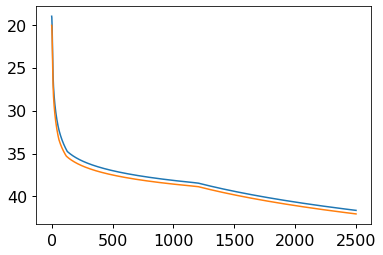

In [27]:
# Turning PSF fitting results into a surface brightness profile

rad_psf = np.linspace(0,1000,2000)
flux_psf_r = (1-psf_r.frac)*psf_r.f_core1D(rad_psf) + psf_r.frac*psf_r.f_aureole1D(rad_psf)
mags_psf_r = gp.flux_to_mags(flux_psf_r, 0, zerop_r)
r_shift = mags_psf_r[0] - SB_r[0]
mags_psf_r = mags_psf_r - r_shift

flux_psf_g = (1-psf_g.frac)*psf_r.f_core1D(rad_psf) + psf_g.frac*psf_g.f_aureole1D(rad_psf)
mags_psf_g = gp.flux_to_mags(flux_psf_g, 0, zerop_g)
g_shift = mags_psf_g[0] - SB_g[0]
mags_psf_g = mags_psf_g - g_shift

# Quick plot for a sanity check
plt.plot(rad_psf*pix_size, mags_psf_r)
plt.plot(rad_psf*pix_size, mags_psf_g)

plt.gca().invert_yaxis()

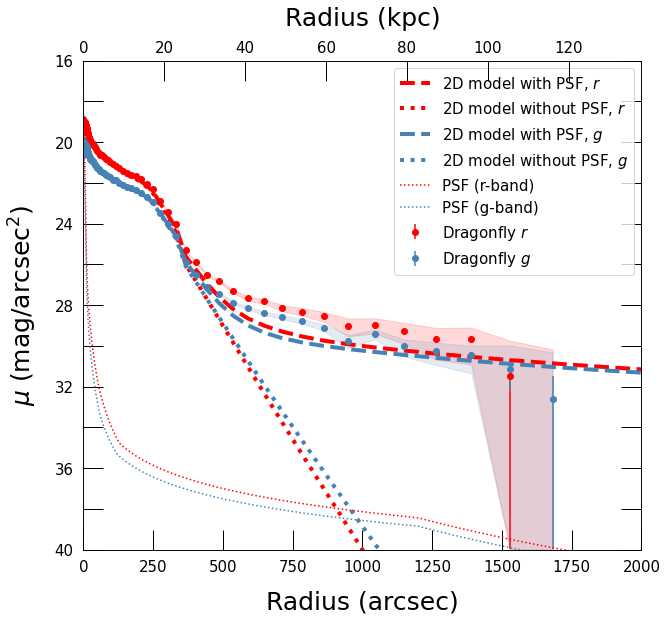

In [28]:
# Plotting comparison of model profiles (and PSF) with observed profiles

fig, ax = plt.subplots()

# Observed
ax.errorbar(rad_r*pix_size, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="r", label="Dragonfly $r$")
ax.errorbar(rad_g*pix_size, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="steelblue", label="Dragonfly $g$")
plt.fill_between(rad_r*pix_size, err_r_ps - extinct_r, err_r_ms - extinct_r, alpha=0.15, color="r")
plt.fill_between(rad_g*pix_size, err_g_ps - extinct_g, err_g_ms - extinct_g, alpha=0.15, color="steelblue")

# Model
plt.plot(isophotes_model_fixed.sma*pix_size, gp.flux_to_mags(isophotes_model_fixed.intens, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(isophotes_model_noPSF_fixed.sma*pix_size, gp.flux_to_mags(isophotes_model_noPSF_fixed.intens, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")

plt.plot(isophotes_model_g_fixed.sma*pix_size, gp.flux_to_mags(isophotes_model_g_fixed.intens, 0.0, zerop_g), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")
plt.plot(isophotes_model_g_noPSF_fixed.sma*pix_size, gp.flux_to_mags(isophotes_model_g_noPSF_fixed.intens, 0.0, zerop_g), ":", c="steelblue", lw=4, label="2D model without PSF, $g$")

# PSFs for each band
plt.plot(rad_psf*pix_size, mags_psf_r, 'r:', label="PSF (r-band)")
plt.plot(rad_psf*pix_size, mags_psf_g, ':', color="steelblue", label="PSF (g-band)")

plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*2000) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 2000)
ax.set_ylim(40, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36", "", "40"])

fig.set_size_inches(10,9)
plt.show()


## Colour profile

Errors on surface brightness profiles have been shown as flux errors (asymmetric in magnitude space). Errors on colour profiles are calculated in magnitude units (symmetric in magnitude space). Some intermediate values saved inside the QuadrantProfiles objects are passed along to calculate colour errors. All of the zero arguments are for sky and sky errors, as these are already incorporated in the flux values.

In [29]:
# Colour and error (without and with sys. uncertainty in sky)
gmr = SB_g - SB_r - extinct_g + extinct_r

gmr_err = gp.calc_colour_error(quads_g.combinedFlux, 
                                quads_g.combinedFluxErr, 
                                quads_r.combinedFlux, 
                                quads_r.combinedFluxErr, 
                                0, 
                                0, 
                                0, 
                                0)

gmr_err_sys =  gp.calc_colour_error(quads_g.combinedFlux, 
                                   quads_g.combinedFluxSysErr, 
                                   quads_r.combinedFlux, 
                                   quads_r.combinedFluxSysErr, 
                                   0, 
                                   0, 
                                   0, 
                                   0)

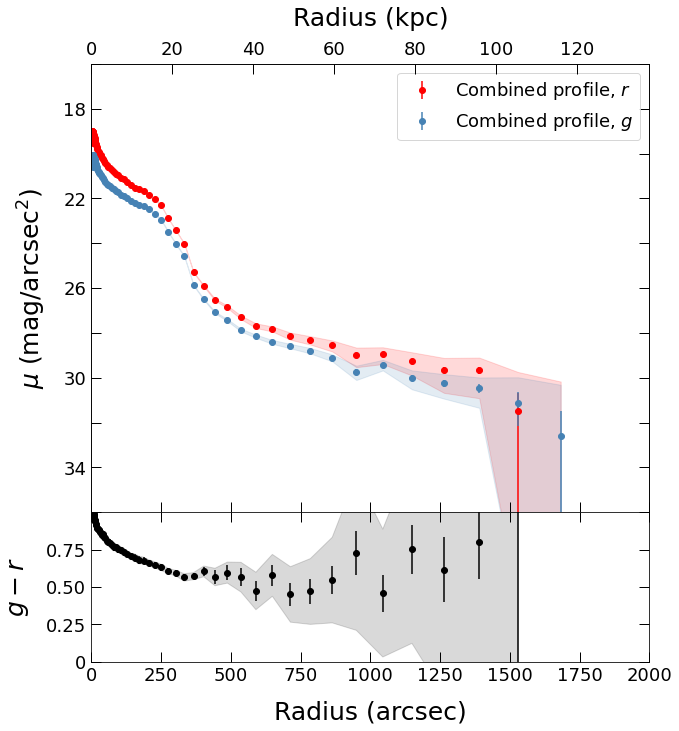

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=2)
gs1 = gridspec.GridSpec(2,1,wspace=0,hspace=0, height_ratios = [3,1])

################################################################################
# Surface brightness profiles
ax0 = plt.subplot(gs1[0])

ax0.errorbar(rad_r*pix_size, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="r", label="Combined profile, $r$")
ax0.errorbar(rad_g*pix_size, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="steelblue", label="Combined profile, $g$")
ax0.fill_between(rad_r*pix_size, err_r_ps - extinct_r, err_r_ms - extinct_r, alpha=0.15, color="r")
ax0.fill_between(rad_g*pix_size, err_g_ps - extinct_g, err_g_ms - extinct_g, alpha=0.15, color="steelblue")

leg = plt.legend(prop={'size': 18})

ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax0.xaxis.set_tick_params(which='major',size=10,pad=5,right=True, direction="in")

# Secondary x axis for physical length scales
ax00 = ax0.twiny()
ax00.set_xlim(0,kpc_factor*2000) 
ax00.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax00.xaxis.set_tick_params(which='major',size=10,pad=5,top=True, bottom=False, direction="in")

ax0.set_xlim(0, 2000)
ax0.set_xticklabels([])

ax0.set_ylim(36, 16)
ax0.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax0.set_yticklabels(["", "18", "", "22", "", "26", "", "30", "", "34", "" ])

################################################################################
# g-r colour profiles
ax1 = plt.subplot(gs1[1])

ax1.errorbar(np.array(rad_r)*pix_size, gmr, yerr=gmr_err, fmt='o', label=r"$g-r$", color='k')
ax1.fill_between(np.array(rad_r)*pix_size, np.array(gmr) + np.array(gmr_err_sys), np.array(gmr) - np.array(gmr_err_sys), alpha=0.15, color="k")

ax1.set_ylabel(r"$g-r$", size=25, labelpad=15)
ax1.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax1.set_ylim(0,1)
ax1.set_yticks([0.0 ,0.25, 0.5, 0.75, 1.0])
ax1.set_yticklabels(["0", "0.25", "0.50", "0.75", ""])

ax1.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax1.set_xlim(0,2000)

################################################################################
for a in [ax0, ax1, ax00]:
    
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")
    a.tick_params(labelsize=18)

fig.set_size_inches(10, 11)
plt.show()

## Smoothing outer isophote ellipticity

The photutils.isophote.Ellipse fitting of position angle and ellipticity halts where disk light still dominates (due to decreasing S/N and sometimes increasing fraction of masked or rejected pixels). Beyond this radius, a fixed position angle and ellipticity are adopted. This isophote shape is often not representative of the light distribution in the galaxy's outskirts. 

It is possible to extend the isophote shape-fitting slightly by adjusting some of the parameters of the fit run, but it is more expedient to manually add a smooth decline in isophote ellipticity. The radial range of the decline and the target outer ellipticity are identified by inspecting the source-subtracted images in ds9 and placing elliptical regions on the image. The outer ellipticity is simply estimated, not measured, and does *not* constitute an assessment of the flattening (c/a) of the stellar halo. 

Note that the position angle remains fixed, and so the assumption is that the disk and thick disk/stellar halo components are aligned relative to the plane of the sky. Visually, this should be a fine assumption for most cases.

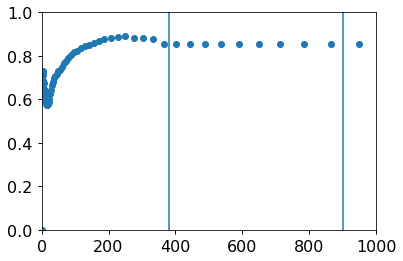

In [31]:
plt.scatter(isophotes_r.sma*pix_size, isophotes_r.eps)

plt.axvline(x=380)
plt.axvline(x=900)

plt.xlim([0,1000])
plt.ylim([0,1])
plt.show()

In [32]:
image_r_masked = np.ma.masked_array(image_r_sub, mask > 0)
image_g_masked = np.ma.masked_array(image_g_sub, mask > 0)

isophotes_r_round = gp.roundify_outer_isophotes(image_r_masked, isophotes_r, 380/pix_size, r_stop=900/pix_size, target_eps=0.4, central_isophote=True)
isophotes_g_round = gp.impose_isophotes(image_g_masked, isophotes_r_round, central_isophote=True)

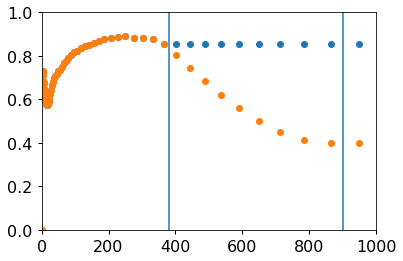

In [33]:
# Quick plot of ellipticity profiles before and after

plt.scatter(isophotes_r.sma*pix_size, isophotes_r.eps)
plt.scatter(isophotes_r_round.sma*pix_size, isophotes_r_round.eps)

plt.axvline(x=380)
plt.axvline(x=900)

plt.xlim([0,1000])
plt.ylim([0,1])
plt.show()

Quadrant and source mask for quad 0:


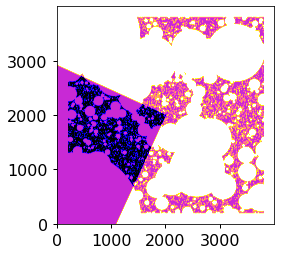

Quadrant and source mask for quad 1:


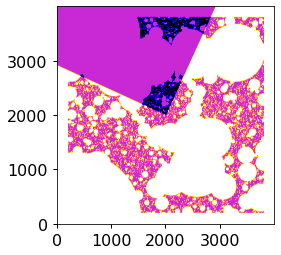

Quadrant and source mask for quad 2:


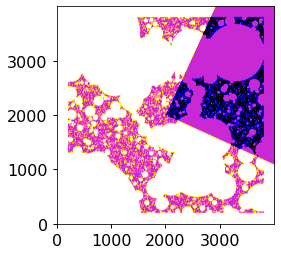

Quadrant and source mask for quad 3:


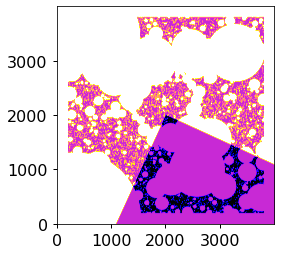

Quadrant and source mask for quad 0:


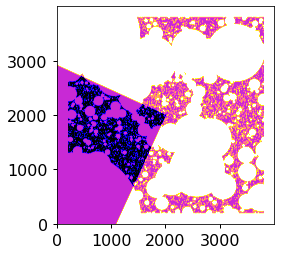

Quadrant and source mask for quad 1:


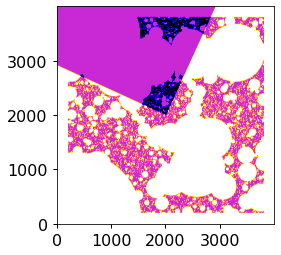

Quadrant and source mask for quad 2:


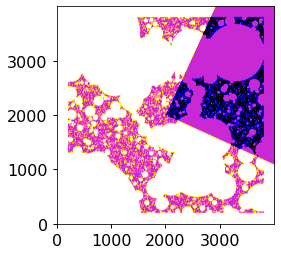

Quadrant and source mask for quad 3:


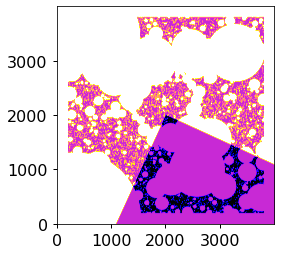

Measuring sky for quadrant 0 ...


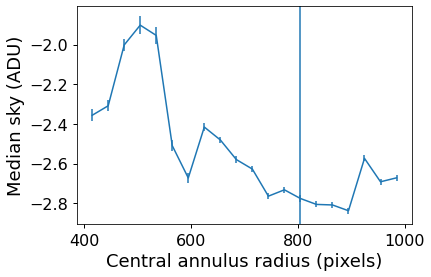

Measuring sky for quadrant 1 ...


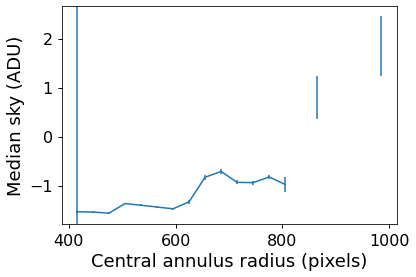

Measuring sky for quadrant 2 ...


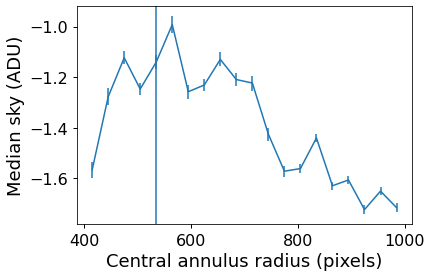

Measuring sky for quadrant 3 ...


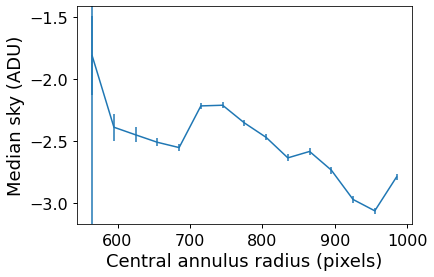

Measuring sky for quadrant 0 ...


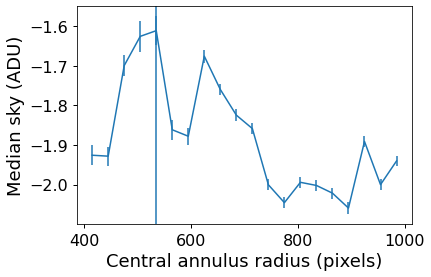

Measuring sky for quadrant 1 ...


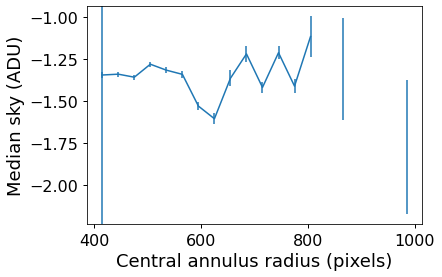

Measuring sky for quadrant 2 ...


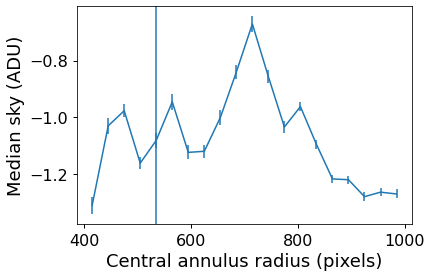

Measuring sky for quadrant 3 ...


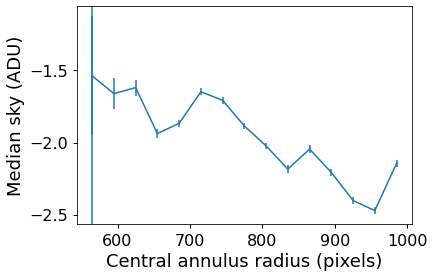

In [34]:
# Re-extracting quadrant profiles using the new rounded isophotes

quads_r_round = QuadrantProfiles(image_r_sub, mask, isophotes_r_round, (y0_2D, x0_2D), PA_0)
quads_g_round = QuadrantProfiles(image_g_sub, mask, isophotes_r_round, (y0_2D, x0_2D), PA_0)

quads_r_round.measure_sky(image_r_sub, 400, 1000, bin_width=30, baseline=3, method="thresh_score", thresh=0.005, mask=mask_asymm)
quads_g_round.measure_sky(image_g_sub, 400, 1000, bin_width=30, baseline=3, method="thresh_score", thresh=0.005, mask=mask_asymm)

Quadrant and source mask for quad 0:


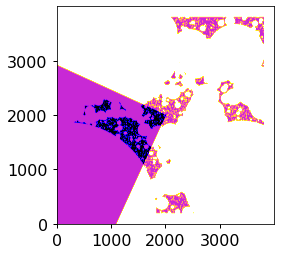

Quadrant and source mask for quad 1:


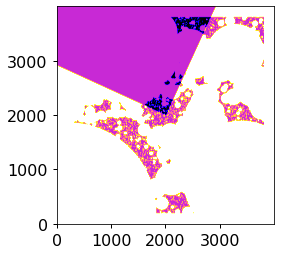

Quadrant and source mask for quad 2:


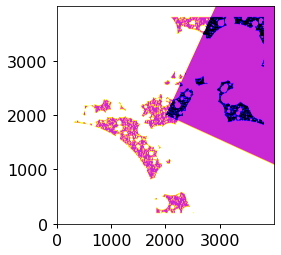

Quadrant and source mask for quad 3:


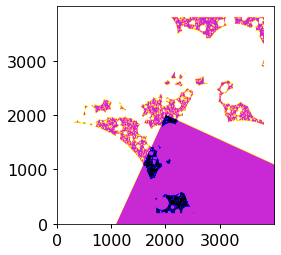

Quadrant and source mask for quad 0:


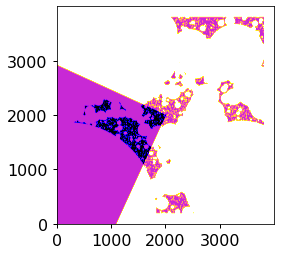

Quadrant and source mask for quad 1:


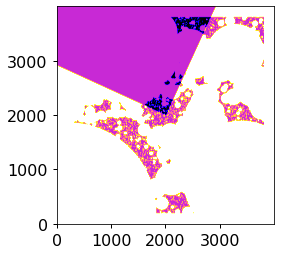

Quadrant and source mask for quad 2:


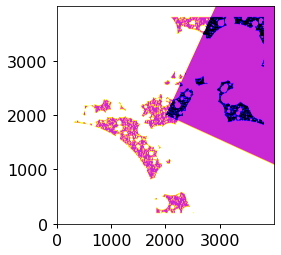

Quadrant and source mask for quad 3:


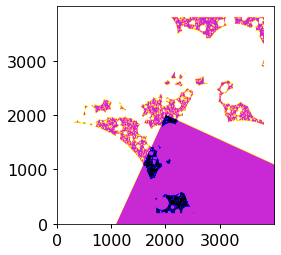

Measuring sky for quadrant 0 ...


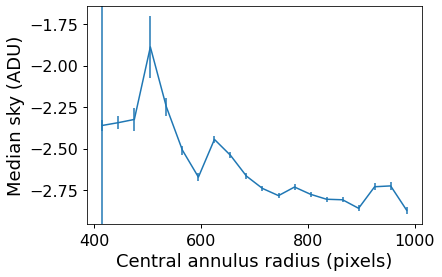

Measuring sky for quadrant 1 ...


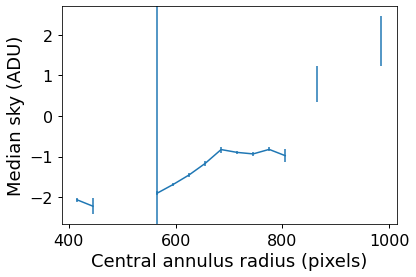

Measuring sky for quadrant 2 ...


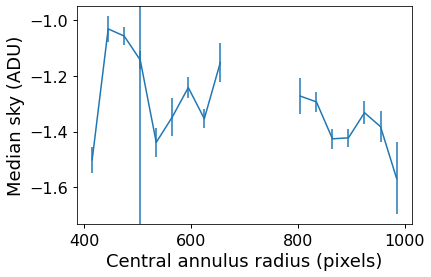

Measuring sky for quadrant 3 ...


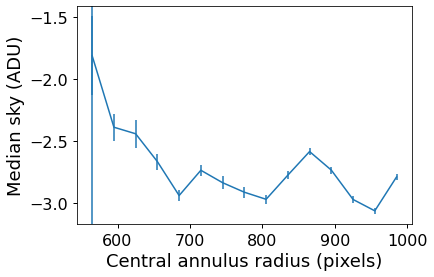

Measuring sky for quadrant 0 ...


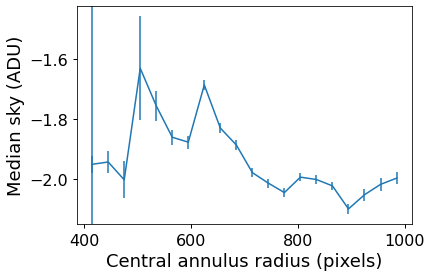

Measuring sky for quadrant 1 ...


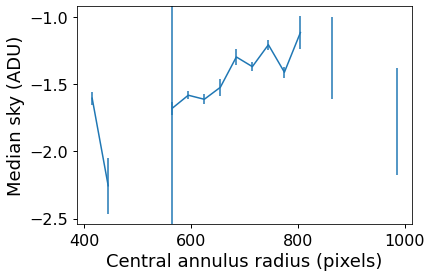

Measuring sky for quadrant 2 ...


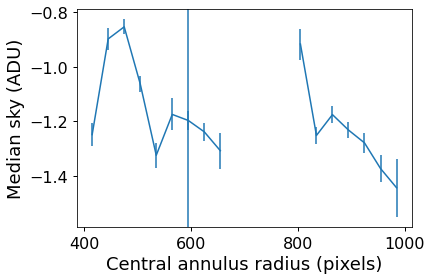

Measuring sky for quadrant 3 ...


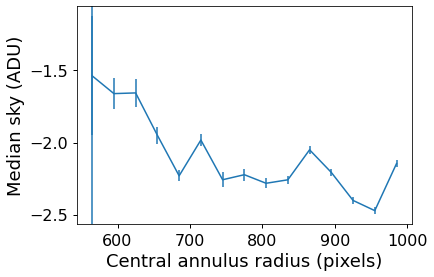

In [35]:
quads_r2_round = QuadrantProfiles(image_r_sub, mask2, isophotes_r_round, (y0_2D, x0_2D), PA_0)
quads_g2_round = QuadrantProfiles(image_g_sub, mask2, isophotes_r_round, (y0_2D, x0_2D), PA_0)

quads_r2_round.measure_sky(image_r_sub, 400, 1000, bin_width=30, baseline=3, method="thresh_score", thresh=0.005, mask=mask2_asymm)
quads_g2_round.measure_sky(image_g_sub, 400, 1000, bin_width=30, baseline=3, method="thresh_score", thresh=0.005, mask=mask2_asymm)

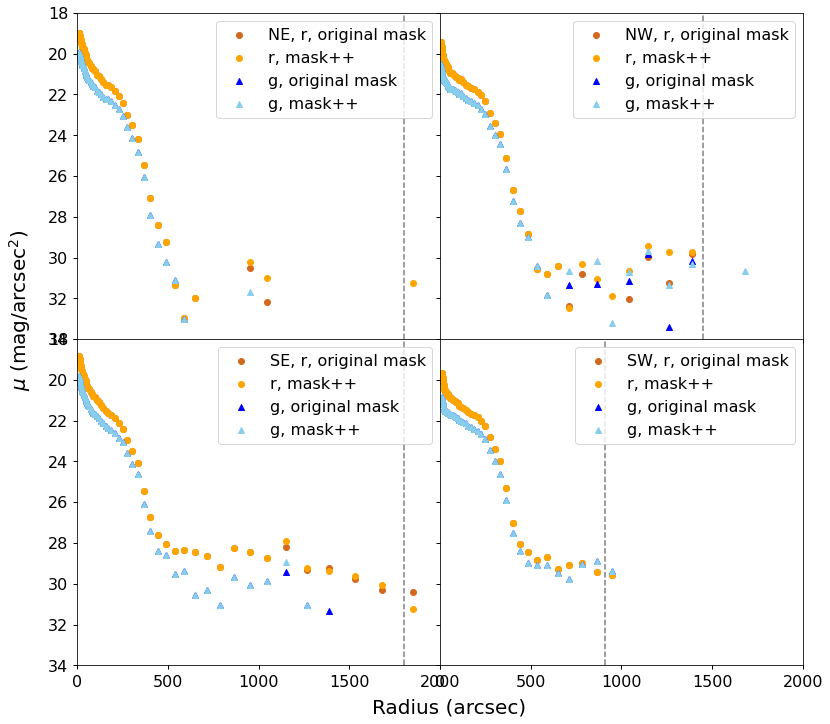

In [36]:
max_r_round = [1800, 1800, 1450, 910]   

fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

a = [ax[1,0], ax[0,0], ax[0,1], ax[1,1]]
qlabel = ["SE", "NE", "NW", "SW"]

for i in range(0,4):
    
    a[i].scatter(quads_r_round.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_r_round.quadIsophotes[i].intens, quads_r_round.quadSky[i], zerop_r), label = f"{qlabel[i]}, r, original mask", color='chocolate')
    a[i].scatter(quads_r2_round.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_r2_round.quadIsophotes[i].intens, quads_r_round.quadSky[i], zerop_r), label = "r, mask++", color='orange')
    a[i].scatter(quads_g_round.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_g_round.quadIsophotes[i].intens, quads_g_round.quadSky[i], zerop_g), label = "g, original mask", color='b', marker='^')
    a[i].scatter(quads_g2_round.quadIsophotes[i].sma*pix_size, gp.flux_to_mags(quads_g2_round.quadIsophotes[i].intens, quads_g_round.quadSky[i], zerop_g), label = "g, mask++", color='skyblue', marker='^')
    a[i].axvline(x=max_r_round[i], ls='--', color='k', alpha=0.5)
    
    a[i].set_xlim(0, 2000)
    a[i].set_ylim(34, 18)
    a[i].legend(loc=1)

ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
ax[1,1].set_yticklabels([])  

fig.text(0.44, 0.07, "Radius (arcsec)", size=20)
fig.text(0.05, 0.45, r"$\mu$ (mag/arcsec$^2$)", size=20, rotation=90)

fig.set_size_inches(13, 12)
plt.show()

In [37]:
quads_r_round.set_quad_limits(max_r_round)
quads_g_round.set_quad_limits(max_r_round)

quads_r2_round.set_quad_limits(max_r_round)
quads_g2_round.set_quad_limits(max_r_round)

In [38]:
# Producing combined profiles with round(er) quadrant profiles

rad_r_round, SB_r_round, err_r_p_round, err_r_m_round, err_r_ps_round, err_r_ms_round = quads_r_round.combine_quad_profiles(isophotes_r_round, 
                                                                                  r_skies,  
                                                                                  zerop_r)

err_all_tmp = [SB_r_round - err_r_p_round, err_r_m_round - SB_r_round]
SB_err_r_round = np.array(err_all_tmp)


rad_g_round, SB_g_round, err_g_p_round, err_g_m_round, err_g_ps_round, err_g_ms_round = quads_g_round.combine_quad_profiles(isophotes_g_round, 
                                                                                  g_skies,  
                                                                                  zerop_g)

err_all_tmp = [SB_g_round - err_g_p_round, err_g_m_round - SB_g_round]
SB_err_g_round = np.array(err_all_tmp)

In [39]:
# Colour and error (without and with sys. uncertainty in sky)

gmr_round = SB_g_round - SB_r_round - extinct_g + extinct_r

gmr_round_err = gp.calc_colour_error(quads_g_round.combinedFlux, 
                                quads_g_round.combinedFluxErr, 
                                quads_r_round.combinedFlux, 
                                quads_r_round.combinedFluxErr, 
                                0, 
                                0, 
                                0, 
                                0)

gmr_round_err_sys =  gp.calc_colour_error(quads_g_round.combinedFlux, 
                                   quads_g_round.combinedFluxSysErr, 
                                   quads_r_round.combinedFlux, 
                                   quads_r_round.combinedFluxSysErr, 
                                   0, 
                                   0, 
                                   0, 
                                   0)

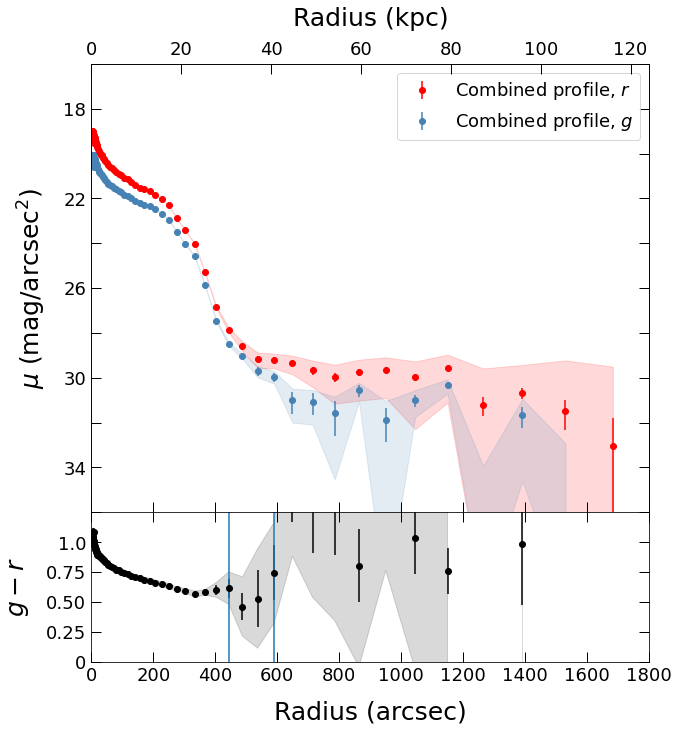

In [40]:
# Taking a look at new round(er) surface brightness and colour profiles

# Defining range of last reliable points in colour profile
colour_avg_range_round = [450,600]  # in arcsec

# Converting radius range to index range
range_index_round = [min(range(len(rad_r)), key=lambda x: abs(rad_r[x]-colour_avg_range_round[0]/2.5)),
                     min(range(len(rad_r)), key=lambda x: abs(rad_r[x]-colour_avg_range_round[1]/2.5))]


fig, ax = plt.subplots(ncols=1, nrows=2)
gs1 = gridspec.GridSpec(2,1,wspace=0,hspace=0, height_ratios = [3,1])

################################################################################
# Surface brightness profiles
ax0 = plt.subplot(gs1[0])

ax0.errorbar(rad_r_round*pix_size, SB_r_round - extinct_r, yerr=SB_err_r_round, fmt='o', c="r", label="Combined profile, $r$")
ax0.errorbar(rad_g_round*pix_size, SB_g_round - extinct_g, yerr=SB_err_g_round, fmt='o', c="steelblue", label="Combined profile, $g$")
ax0.fill_between(rad_r_round*pix_size, err_r_ps_round - extinct_r, err_r_ms_round - extinct_r, alpha=0.15, color="r")
ax0.fill_between(rad_g_round*pix_size, err_g_ps_round - extinct_g, err_g_ms_round - extinct_g, alpha=0.15, color="steelblue")

leg = plt.legend(prop={'size': 18})

ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax0.xaxis.set_tick_params(which='major',size=10,pad=5,right=True, direction="in")

# Secondary x axis for physical length scales
ax00 = ax0.twiny()
ax00.set_xlim(0,kpc_factor*1800) 
ax00.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax00.xaxis.set_tick_params(which='major',size=10,pad=5,top=True, bottom=False, direction="in")

ax0.set_xlim(0, 1800)
ax0.set_xticklabels([])

ax0.set_ylim(36, 16)
ax0.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax0.set_yticklabels(["", "18", "", "22", "", "26", "", "30", "", "34", "" ])

################################################################################
# g-r colour profiles
ax1 = plt.subplot(gs1[1])

ax1.errorbar(rad_r_round*pix_size, gmr_round, yerr=gmr_round_err, fmt='o', label=r"$g-r$", color='k')
ax1.fill_between(rad_r_round*pix_size, gmr_round + gmr_round_err_sys, gmr_round - gmr_round_err_sys, alpha=0.15, color="k")

# Radial range where fixed outer colour is determined
ax1.axvline(x=rad_r[range_index_round[0]]*pix_size)
ax1.axvline(x=rad_r[range_index_round[1]]*pix_size)

ax1.set_ylabel(r"$g-r$", size=25, labelpad=15)
ax1.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax1.set_ylim(0,1)
ax1.set_yticks([0.0 ,0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_yticklabels(["0", "0.25", "0.50", "0.75", "1.0", ""])

ax1.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax1.set_xlim(0,1800)

################################################################################
for a in [ax0, ax1, ax00]:
    
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")
    a.tick_params(labelsize=18)

fig.set_size_inches(10, 11)
plt.show()

In [41]:
# Imposing the round(er) isophotes on the model images

isophotes_model_round = gp.impose_isophotes(image_r_model_PSF, isophotes_r_round, central_isophote=True)
isophotes_model_noPSF_round = gp.impose_isophotes(image_r_model_noPSF, isophotes_r_round, central_isophote=True)

isophotes_model_g_round = gp.impose_isophotes(image_g_model_PSF, isophotes_r_round, central_isophote=True)
isophotes_model_g_noPSF_round = gp.impose_isophotes(image_g_model_noPSF, isophotes_r_round, central_isophote=True)

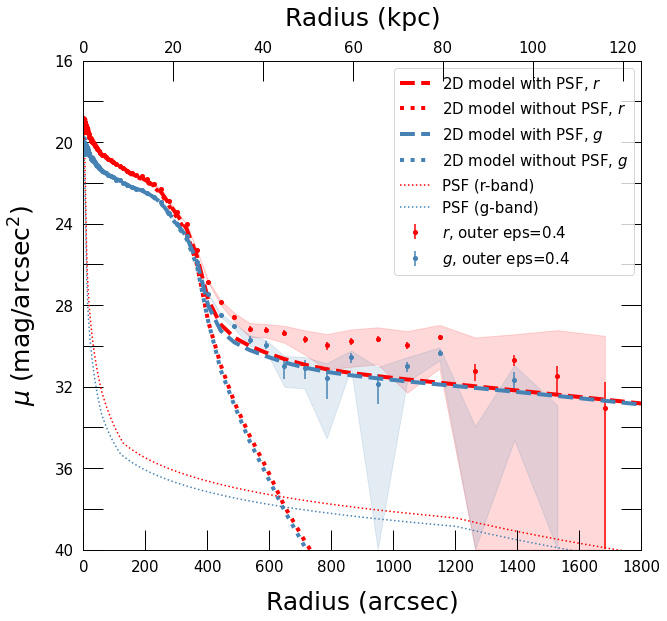

In [42]:
# Plotting comparison of observed and model surface brightness profiles 

fig, ax = plt.subplots()

ax.errorbar(rad_r_round*pix_size, SB_r_round - extinct_r, yerr=SB_err_r_round, fmt='o', c="r", label="$r$, outer eps=0.4", markersize=4)
ax.errorbar(rad_g_round*pix_size, SB_g_round - extinct_g, yerr=SB_err_g_round, fmt='o', c="steelblue", label="$g$, outer eps=0.4", markersize=4)
ax.fill_between(rad_r_round*pix_size, err_r_ps_round - extinct_r, err_r_ms_round - extinct_r, alpha=0.15, color="r")
ax.fill_between(rad_g_round*pix_size, err_g_ps_round - extinct_g, err_g_ms_round - extinct_g, alpha=0.15, color="steelblue")


plt.plot(isophotes_model_round.sma*pix_size, gp.flux_to_mags(isophotes_model_round.intens, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(isophotes_model_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_noPSF_round.intens, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")

plt.plot(isophotes_model_g_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_round.intens, 0.0, zerop_g), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")
plt.plot(isophotes_model_g_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_noPSF_round.intens, 0.0, zerop_g), ":", c="steelblue", lw=4, label="2D model without PSF, $g$")

plt.plot(rad_psf*pix_size, mags_psf_r, 'r:', label="PSF (r-band)")
plt.plot(rad_psf*pix_size, mags_psf_g, ':', color="steelblue", label="PSF (g-band)")

plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 1800)
ax.set_ylim(40, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36", "", "40"])

fig.set_size_inches(10,9)
plt.show()

## Subtracting (estimated) scattered disk light

The purpose of generating model images with and without PSF convolution is to approximate the light from the bright inner parts of the galaxy. The model image without PSF convolution approximates the true distribution of galaxy light and the model image with PSF convolution shows how this light distribution changes due to scattered light. The relative difference between the two models is small where the galaxy is bright and becomes larger in the faint outer regions.

We attempt to counteract the effect of scattered light by subtracting the model difference profile (PSF_profile - noPSF_profile) from the observed surface brightness profile. The goal is to remove light scattered from the bright inner regions of the galaxy, which otherwise is a significant fraction of the light observed at large radii. This will also have the effect of slightly increasing the observed profile at small radii. 

In [43]:
model_flux_r_scattered = isophotes_model_round.intens - isophotes_model_noPSF_round.intens
model_flux_g_scattered = isophotes_model_g_round.intens - isophotes_model_g_noPSF_round.intens

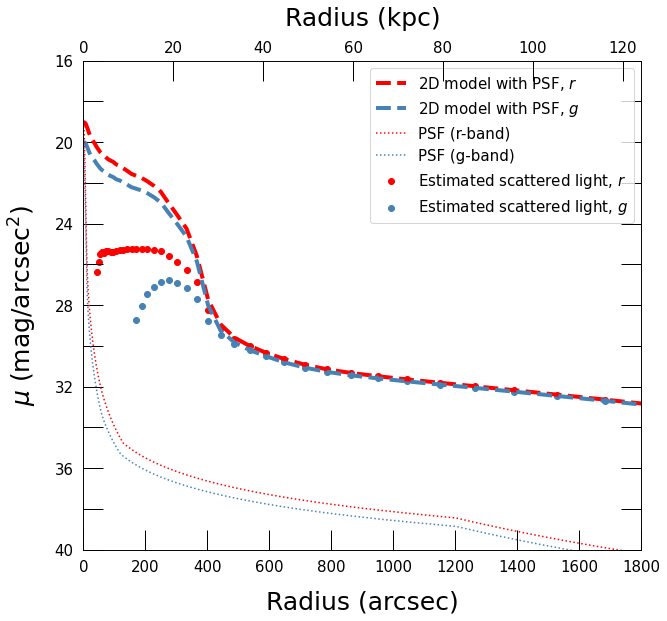

In [44]:
# Plotting the scattered light difference profile alongside model profiles

fig, ax = plt.subplots()

#ax.errorbar(rad_r_round*pix_size, SB_r_round - extinct_r, yerr=SB_err_r_round, fmt='o', c="r", label="$r$, outer eps=0.2", markersize=4)
#ax.errorbar(rad_g_round*pix_size, SB_g_round - extinct_g, yerr=SB_err_g_round, fmt='o', c="steelblue", label="$g$, outer eps=0.2", markersize=4)
#ax.fill_between(rad_r_round*pix_size, err_r_ps_round - extinct_r, err_r_ms_round - extinct_r, alpha=0.15, color="r")
#ax.fill_between(rad_g_round*pix_size, err_g_ps_round - extinct_g, err_g_ms_round - extinct_g, alpha=0.15, color="steelblue")

plt.plot(isophotes_model_round.sma*pix_size, gp.flux_to_mags(isophotes_model_round.intens, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(isophotes_model_g_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_round.intens, 0.0, zerop_g), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")

plt.scatter(isophotes_model_round.sma*pix_size, gp.flux_to_mags(model_flux_r_scattered, 0.0, zerop_r), color='r', label="Estimated scattered light, $r$")
plt.scatter(isophotes_model_round.sma*pix_size, gp.flux_to_mags(model_flux_g_scattered, 0.0, zerop_g), color='steelblue', label="Estimated scattered light, $g$")

plt.plot(rad_psf*pix_size, mags_psf_r, 'r:', label="PSF (r-band)")
plt.plot(rad_psf*pix_size, mags_psf_g, ':', color="steelblue", label="PSF (g-band)")

plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 1800)
ax.set_ylim(40, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36", "", "40"])

fig.set_size_inches(10,9)
plt.show()

In [45]:
# Calculating scattered light-"corr"ected surface brightness profiles and associated errors

SB_r_corr = gp.flux_to_mags(quads_r_round.combinedFlux - model_flux_r_scattered, 0, zerop_r)
SB_g_corr = gp.flux_to_mags(quads_g_round.combinedFlux - model_flux_g_scattered, 0, zerop_g)

flux_r_corr_err = np.sqrt(quads_r_round.combinedFluxErr**2 + isophotes_model_g_round.int_err**2 + isophotes_model_g_noPSF_round.int_err**2)
flux_g_corr_err = np.sqrt(quads_g_round.combinedFluxErr**2 + isophotes_model_g_round.int_err**2 + isophotes_model_g_noPSF_round.int_err**2)

flux_r_corr_syserr = np.sqrt(quads_r_round.combinedFluxSysErr**2 + isophotes_model_g_round.int_err**2 + isophotes_model_g_noPSF_round.int_err**2)
flux_g_corr_syserr = np.sqrt(quads_g_round.combinedFluxSysErr**2 + isophotes_model_g_round.int_err**2 + isophotes_model_g_noPSF_round.int_err**2)

SB_r_corr_err_p = gp.flux_to_mags(quads_r_round.combinedFlux - model_flux_r_scattered + flux_r_corr_err, 0, zerop_r, default=40)
SB_r_corr_err_m = gp.flux_to_mags(quads_r_round.combinedFlux - model_flux_r_scattered - flux_r_corr_err, 0, zerop_r, default=40)
SB_g_corr_err_p = gp.flux_to_mags(quads_g_round.combinedFlux - model_flux_g_scattered + flux_g_corr_err, 0, zerop_g, default=40)
SB_g_corr_err_m = gp.flux_to_mags(quads_g_round.combinedFlux - model_flux_g_scattered - flux_g_corr_err, 0, zerop_g, default=40)

SB_err_r_corr_ps = gp.flux_to_mags(quads_r_round.combinedFlux - model_flux_r_scattered + flux_r_corr_syserr, 0, zerop_r, default=40)
SB_err_r_corr_ms = gp.flux_to_mags(quads_r_round.combinedFlux - model_flux_r_scattered - flux_r_corr_syserr, 0, zerop_r, default=40)
SB_err_g_corr_ps = gp.flux_to_mags(quads_g_round.combinedFlux - model_flux_g_scattered + flux_g_corr_syserr, 0, zerop_g, default=40)
SB_err_g_corr_ms = gp.flux_to_mags(quads_g_round.combinedFlux - model_flux_g_scattered - flux_g_corr_syserr, 0, zerop_g, default=40)

err_all_tmp = [SB_r_corr - SB_r_corr_err_p, SB_r_corr_err_m - SB_r_corr]
SB_err_r_corr = np.array(err_all_tmp)

err_all_tmp = [SB_g_corr - SB_g_corr_err_p, SB_g_corr_err_m - SB_g_corr]
SB_err_g_corr = np.array(err_all_tmp)

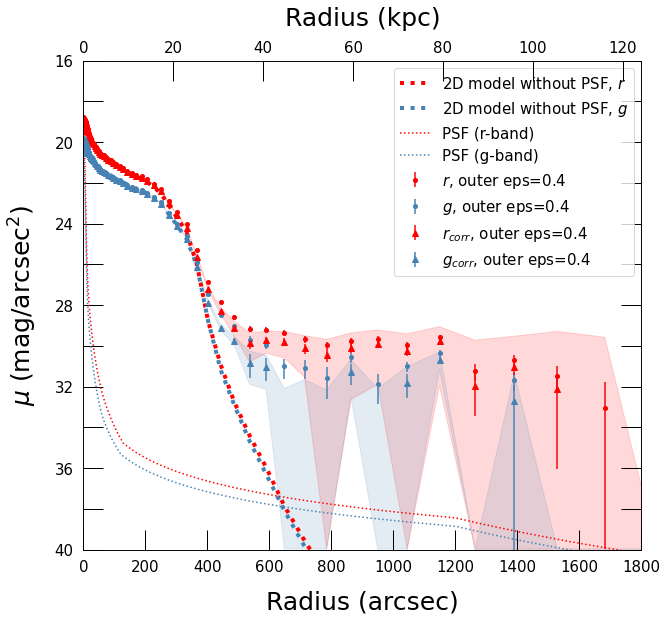

In [46]:
# Plotting comparison of surface brightness profiles before and after scattered light correction

fig, ax = plt.subplots()

ax.errorbar(rad_r_round*pix_size, SB_r_round - extinct_r, yerr=SB_err_r_round, fmt='o', c="r", label="$r$, outer eps=0.4", markersize=4)
ax.errorbar(rad_g_round*pix_size, SB_g_round - extinct_g, yerr=SB_err_g_round, fmt='o', c="steelblue", label="$g$, outer eps=0.4", markersize=4)

ax.errorbar(rad_r_round*pix_size, SB_r_corr, yerr=SB_err_r_corr, fmt='o', marker='^', color='r', label="$r_{corr}$, outer eps=0.4")
ax.errorbar(rad_r_round*pix_size, SB_g_corr, yerr=SB_err_g_corr, fmt='o', marker='^', color='steelblue', label="$g_{corr}$, outer eps=0.4")
ax.fill_between(rad_r_round*pix_size, SB_err_r_corr_ps - extinct_r, SB_err_r_corr_ms - extinct_r, alpha=0.15, color="r")
ax.fill_between(rad_g_round*pix_size, SB_err_g_corr_ps - extinct_g, SB_err_g_corr_ms - extinct_g, alpha=0.15, color="steelblue")


#plt.plot(isophotes_model_round.sma*pix_size, gp.flux_to_mags(isophotes_model_round.intens, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(isophotes_model_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_noPSF_round.intens, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")

#plt.plot(isophotes_model_g_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_round.intens, 0.0, zerop_g), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")
plt.plot(isophotes_model_g_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_noPSF_round.intens, 0.0, zerop_g), ":", c="steelblue", lw=4, label="2D model without PSF, $g$")

plt.plot(rad_psf*pix_size, mags_psf_r, 'r:', label="PSF (r-band)")
plt.plot(rad_psf*pix_size, mags_psf_g, ':', color="steelblue", label="PSF (g-band)")

plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 1800)
ax.set_ylim(40, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36", "", "40"])

fig.set_size_inches(10,9)
plt.show()

In [47]:
# Scattered light corrected colour profile and error (without and with sys. uncertainty in sky)

gmr_corr = SB_g_corr - SB_r_corr - extinct_g + extinct_r

gmr_corr_err = gp.calc_colour_error(quads_g_round.combinedFlux - model_flux_g_scattered, 
                                    flux_g_corr_err, 
                                    quads_r_round.combinedFlux - model_flux_r_scattered, 
                                    flux_r_corr_err, 
                                    0, 
                                    0, 
                                    0, 
                                    0)

gmr_corr_err_sys =  gp.calc_colour_error(quads_g_round.combinedFlux - model_flux_g_scattered, 
                                         flux_r_corr_syserr, 
                                         quads_r_round.combinedFlux - model_flux_r_scattered, 
                                         flux_r_corr_syserr, 
                                         0, 
                                         0, 
                                         0, 
                                         0)

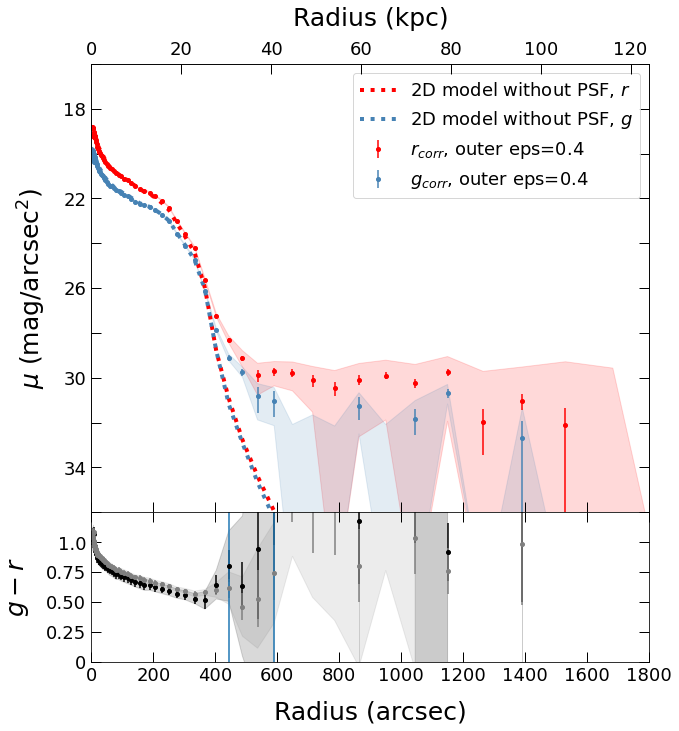

In [48]:
# Plotting corrected surface brightness and colour profiles together

colour_avg_range_corr = [450,600]  # in arcsec

# Converting radius range to index range
range_index_corr = [min(range(len(rad_r)), key=lambda x: abs(rad_r[x]-colour_avg_range_corr[0]/2.5)),
                     min(range(len(rad_r)), key=lambda x: abs(rad_r[x]-colour_avg_range_corr[1]/2.5))]


fig, ax = plt.subplots(ncols=1, nrows=2)
gs1 = gridspec.GridSpec(2,1,wspace=0,hspace=0, height_ratios = [3,1])

################################################################################
# Surface brightness profiles
ax0 = plt.subplot(gs1[0])

ax0.errorbar(rad_r_round*pix_size, SB_r_corr, yerr=SB_err_r_corr, fmt='o', color='r', label="$r_{corr}$, outer eps=0.4", markersize=4)
ax0.errorbar(rad_r_round*pix_size, SB_g_corr, yerr=SB_err_g_corr, fmt='o', color='steelblue', label="$g_{corr}$, outer eps=0.4", markersize=4)
ax0.fill_between(rad_r_round*pix_size, SB_err_r_corr_ps - extinct_r, SB_err_r_corr_ms - extinct_r, alpha=0.15, color="r")
ax0.fill_between(rad_g_round*pix_size, SB_err_g_corr_ps - extinct_g, SB_err_g_corr_ms - extinct_g, alpha=0.15, color="steelblue")

#plt.plot(isophotes_model_round.sma*pix_size, gp.flux_to_mags(isophotes_model_round.intens, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(isophotes_model_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_noPSF_round.intens, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")

#plt.plot(isophotes_model_g_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_round.intens, 0.0, zerop_g), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")
plt.plot(isophotes_model_g_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_noPSF_round.intens, 0.0, zerop_g), ":", c="steelblue", lw=4, label="2D model without PSF, $g$")


leg = plt.legend(prop={'size': 18})

ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax0.xaxis.set_tick_params(which='major',size=10,pad=5,right=True, direction="in")

# Secondary x axis for physical length scales
ax00 = ax0.twiny()
ax00.set_xlim(0,kpc_factor*1800) 
ax00.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax00.xaxis.set_tick_params(which='major',size=10,pad=5,top=True, bottom=False, direction="in")

ax0.set_xlim(0, 1800)
ax0.set_xticklabels([])

ax0.set_ylim(36, 16)
ax0.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax0.set_yticklabels(["", "18", "", "22", "", "26", "", "30", "", "34", "" ])

################################################################################
# g-r colour profiles
ax1 = plt.subplot(gs1[1])

ax1.errorbar(rad_r_round*pix_size, gmr_corr, yerr=gmr_corr_err, fmt='o', label=r"$g-r$", color='k', markersize=4)
ax1.fill_between(rad_r_round*pix_size, gmr_corr + gmr_corr_err_sys, gmr_corr - gmr_corr_err_sys, alpha=0.15, color="k")

ax1.errorbar(rad_r_round*pix_size, gmr_round, yerr=gmr_round_err, fmt='o', label=r"$g-r$", color='grey', markersize=4)
ax1.fill_between(rad_r_round*pix_size, gmr_round + gmr_round_err_sys, gmr_round - gmr_round_err_sys, alpha=0.15, color="grey")


# Radial range where fixed outer colour is determined
ax1.axvline(x=rad_r[range_index_corr[0]]*pix_size)
ax1.axvline(x=rad_r[range_index_corr[1]]*pix_size)

ax1.set_ylabel(r"$g-r$", size=25, labelpad=15)
ax1.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax1.set_ylim(0,1)
ax1.set_yticks([0.0 ,0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_yticklabels(["0", "0.25", "0.50", "0.75", "1.0", ""])

ax1.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax1.set_xlim(0,1800)

################################################################################
for a in [ax0, ax1, ax00]:
    
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")
    a.tick_params(labelsize=18)

fig.set_size_inches(10, 11)
plt.show()

## Surface stellar mass density profiles

Using colour-mass-to-light-ratio (CMLR) relations, a colour profile and an accompanying surface brightness profile can be used to calculate a surface stellar mass density profile. We adopt the (g-r, g) CMLR from Roediger & Courteau (2015): $\textrm{log}(\mathscr{M}_*/L)_g = 2.029(g-r) - 0.984$

Here's the math behind the calculations below:

-----

$\textrm{log}(\Sigma_*) = \textrm{log}\Big((\mathscr{M}_*/L) \times L \times (1/\Omega)^2\Big)$

$\textrm{log}(\Sigma_*) = \textrm{log}(\mathscr{M}_*/L)_g + 0.4(M_{g,\odot} - M_g) + \textrm{log}(1/\Omega)^2$

$\textrm{log}(\Sigma_*) = 2.029(g-r) - 0.984 + 2.044 - 0.4(m_g - [M-m]) + \textrm{log}(1/\Omega)^2$

-----

Solar absolute magnitude ($M_{g,\odot}$) accessed from Willmer (2018): 5.11 mag (0.4*5.11 = 2.044)

Note that pixel area in square arcsec is already baked into $g-r$ and $M_g$, and so $\Omega$ represents the conversion factor from square arcsec to square kpc.

(0.0, 12.0)

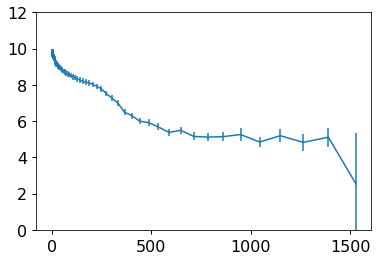

In [49]:
# Surface mass density profile using as-extracted SB profiles (without rounder outer isophotes)

mass_density = -0.4*(SB_g - DM - extinct_g)
mass_density += 2.029*gmr - 0.984 + 2.044
mass_density += np.log10(1/(kpc_factor)**2)

dg = 2.5*np.log10(np.e)*quads_g.combinedFluxErr/quads_g.combinedFlux
dg_sys = 2.5*np.log10(np.e)*quads_g.combinedFluxSysErr/quads_g.combinedFlux

# Random and systematic error in CMLR relations (Roediger & Courteau 2015)
dCMLR = 0.15
dCMLR_sys = 0.3

mass_density_err = np.sqrt((0.4*dg)**2 + (2.029*gmr_err)**2 + dCMLR**2)
mass_density_err_sys = np.sqrt((0.4*dg_sys)**2 + (2.029*gmr_err_sys)**2 + dCMLR**2 + dCMLR_sys**2)

plt.errorbar(rad_r*pix_size, mass_density, yerr=mass_density_err)
plt.ylim([0,12])

(0.0, 12.0)

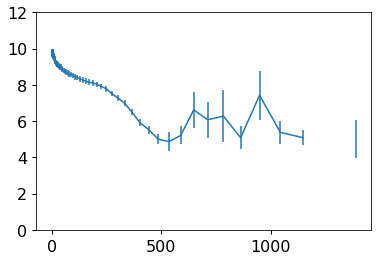

In [50]:
# Surface mass density profile with smoothed/rounded outer isophotes

mass_density_round = -0.4*(SB_g_round - DM - extinct_g)
mass_density_round += 2.029*gmr_round - 0.984 + 2.044
mass_density_round += np.log10(1/(kpc_factor)**2)

dg = 2.5*np.log10(np.e)*quads_g_round.combinedFluxErr/quads_g_round.combinedFlux
dg_sys = 2.5*np.log10(np.e)*quads_g_round.combinedFluxSysErr/quads_g_round.combinedFlux

mass_density_round_err = np.sqrt((0.4*dg)**2 + (2.029*gmr_round_err)**2 + dCMLR**2)
mass_density_round_err_sys = np.sqrt((0.4*dg_sys)**2 + (2.029*gmr_round_err_sys)**2 + dCMLR**2 + dCMLR_sys**2)

plt.errorbar(rad_r_round*pix_size, mass_density_round, yerr=mass_density_round_err)
plt.ylim([0,12])

(0.0, 12.0)

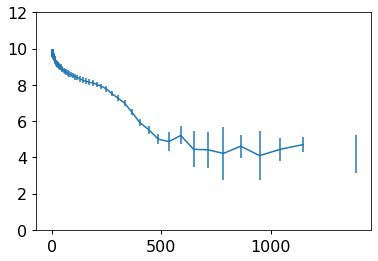

In [51]:
# Holding outer colour profile fixed and recomputing surface mass density profile

outer_gmr_round = np.average(gmr_round[range_index_round[0]:range_index_round[1]+1], weights=1/(gmr_round_err[range_index_round[0]:range_index_round[1]+1])**2)

gmr_round_fixed = np.array([g if i <= range_index_round[1] else outer_gmr_round for i,g in enumerate(gmr_round)])

mass_density_round_fixed = -0.4*(SB_g_round - DM - extinct_g)
mass_density_round_fixed += 2.029*gmr_round_fixed - 0.984 + 2.044
mass_density_round_fixed += np.log10(1/(kpc_factor)**2)

plt.errorbar(rad_r_round*pix_size, mass_density_round_fixed, yerr=mass_density_round_err)
plt.ylim([0,12])

(0.0, 12.0)

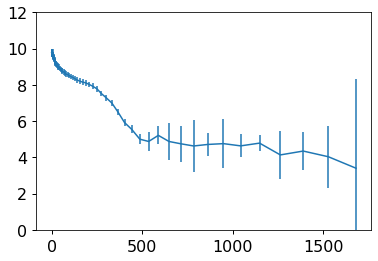

In [52]:
# As above, but using r-band profile + colour in place of g-band profile
# (This will be identical to above except in fixed outer colour regime)
# (Will only use when outer g-band profile is more patchy or suffers some pathology)

mass_density_round_fixed2 = -0.4*(SB_r_round + gmr_round_fixed - DM - extinct_g)
mass_density_round_fixed2 += 2.029*gmr_round_fixed - 0.984 + 2.044
mass_density_round_fixed2 += np.log10(1/(kpc_factor)**2)

plt.errorbar(rad_r_round*pix_size, mass_density_round_fixed2, yerr=mass_density_round_err)
plt.ylim([0,12])

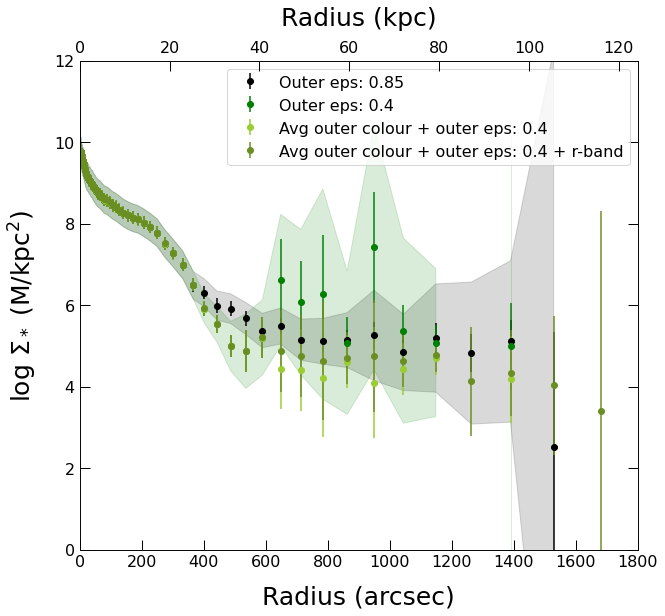

In [53]:
# Plotting all of the surface stellar mass density profiles calculcated above

fig, ax = plt.subplots()

# Default mass density profile
ax.errorbar(rad_r*pix_size, mass_density, yerr=mass_density_err, fmt='o', c="k", label="Outer eps: 0.85")
plt.fill_between(rad_r*pix_size, mass_density - mass_density_err_sys, mass_density + mass_density_err_sys, alpha=0.15, color="k")

# Mass density profile with round(er) outer isophotes
ax.errorbar(rad_r_round*pix_size, mass_density_round, yerr=mass_density_round_err, fmt='o', c="green", label="Outer eps: 0.4")
ax.errorbar(rad_r_round*pix_size, mass_density_round_fixed, yerr=mass_density_round_err, fmt='o', c="yellowgreen", label="Avg outer colour + outer eps: 0.4")
ax.errorbar(rad_r_round*pix_size, mass_density_round_fixed2, yerr=mass_density_round_err, fmt='o', c="olivedrab", label="Avg outer colour + outer eps: 0.4 + r-band")


plt.fill_between(rad_r_round*pix_size, mass_density_round - mass_density_round_err_sys, mass_density_round + mass_density_round_err_sys, alpha=0.15, color="green")


plt.gca().invert_yaxis()

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend()

ax.set_xlim(0, 1800)
ax.set_ylim(0, 12)

fig.set_size_inches(10, 9)
plt.show()

### Surface mass density profiles with (estimated) scattered light removed

Repeating the above calculations, but now using the scattered light-corrected surface brightness and colour profiles.

(0.0, 12.0)

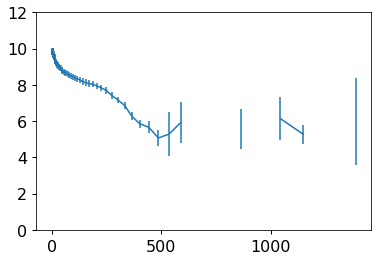

In [54]:
mass_density_corr = -0.4*(SB_g_corr - DM - extinct_g)
mass_density_corr += 2.029*gmr_corr - 0.984 + 2.044
mass_density_corr += np.log10(1/(kpc_factor)**2)

dg = 2.5*np.log10(np.e)*flux_g_corr_err/(quads_g_round.combinedFlux - model_flux_g_scattered)
dg_sys = 2.5*np.log10(np.e)*flux_g_corr_syserr/(quads_g_round.combinedFlux - model_flux_g_scattered)

mass_density_corr_err = np.sqrt((0.4*dg)**2 + (2.029*gmr_corr_err)**2 + dCMLR**2)
mass_density_corr_err_sys = np.sqrt((0.4*dg_sys)**2 + (2.029*gmr_corr_err_sys)**2 + dCMLR**2 + dCMLR_sys**2)

plt.errorbar(rad_r_round*pix_size, mass_density_corr, yerr=mass_density_corr_err)
plt.ylim([0,12])

(0.0, 12.0)

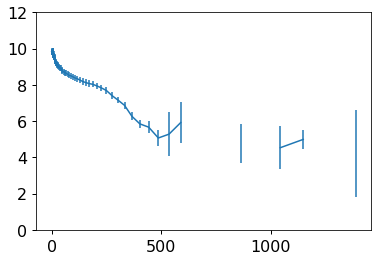

In [55]:
outer_gmr_corr = np.average(gmr_corr[range_index_corr[0]:range_index_corr[1]+1], weights=1/(gmr_corr_err[range_index_corr[0]:range_index_corr[1]+1])**2)

gmr_corr_fixed = np.array([g if i <= range_index_corr[1] else outer_gmr_corr for i,g in enumerate(gmr_corr)])

mass_density_corr_fixed = -0.4*(SB_g_corr - DM - extinct_g)
mass_density_corr_fixed += 2.029*gmr_corr_fixed - 0.984 + 2.044
mass_density_corr_fixed += np.log10(1/(kpc_factor)**2)

plt.errorbar(rad_r_round*pix_size, mass_density_corr_fixed, yerr=mass_density_corr_err)
plt.ylim([0,12])

(0.0, 12.0)

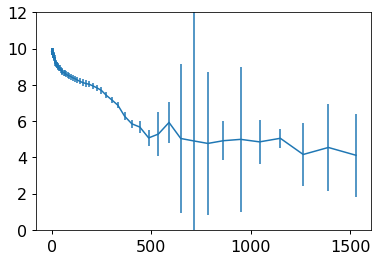

In [56]:
mass_density_corr_fixed2 = -0.4*(SB_r_corr + gmr_corr_fixed - DM - extinct_g)
mass_density_corr_fixed2 += 2.029*gmr_corr_fixed - 0.984 + 2.044
mass_density_corr_fixed2 += np.log10(1/(kpc_factor)**2)

plt.errorbar(rad_r_round*pix_size, mass_density_corr_fixed2, yerr=mass_density_corr_err)
plt.ylim([0,12])

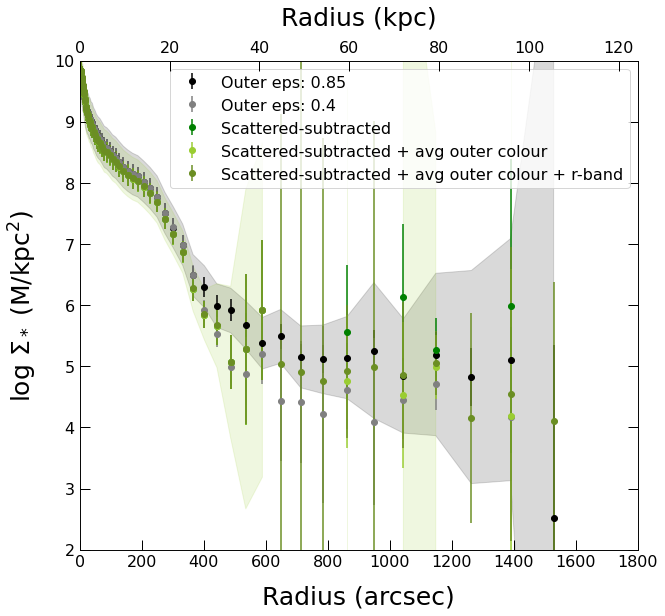

In [57]:
# Plotting all of the surface stellar mass density profiles calculcated above
# The uncorrected profile (no rounded isophotes, no scattered light correction) and the rounded
# profile without scattered light correction are also included for comparison
#
# In general, the preferred approach is to hold outer colour fixed ("mass_density_corr_fixed")

fig, ax = plt.subplots()

# Default mass density profile
ax.errorbar(rad_r*pix_size, mass_density, yerr=mass_density_err, fmt='o', c="k", label="Outer eps: 0.85")
plt.fill_between(rad_r*pix_size, mass_density - mass_density_err_sys, mass_density + mass_density_err_sys, alpha=0.15, color="k")

#ax.errorbar(rad_r_round*pix_size, mass_density_round, yerr=mass_density_round_err, c="green", label="Outer eps: 0.2")
ax.errorbar(rad_r_round*pix_size, mass_density_round_fixed, yerr=mass_density_round_err, fmt='o', c="grey", label="Outer eps: 0.4")
#ax.errorbar(rad_r_round*pix_size, mass_density_round_fixed2, yerr=mass_density_round_err, c="olivedrab", label="Avg outer colour + outer eps: 0.2 + r-band")

ax.errorbar(rad_r_round*pix_size, mass_density_corr, yerr=mass_density_corr_err, fmt='o', c="green", label="Scattered-subtracted")
ax.errorbar(rad_r_round*pix_size, mass_density_corr_fixed, yerr=mass_density_corr_err, fmt='o', c="yellowgreen", label="Scattered-subtracted + avg outer colour")
ax.errorbar(rad_r_round*pix_size, mass_density_corr_fixed2, yerr=mass_density_corr_err, fmt='o', c="olivedrab", label="Scattered-subtracted + avg outer colour + r-band")

plt.fill_between(rad_r_round*pix_size, mass_density_corr_fixed - mass_density_corr_err_sys, mass_density_corr_fixed + mass_density_corr_err_sys, alpha=0.15, color="yellowgreen")

plt.gca().invert_yaxis()

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend(loc=1)

ax.set_xlim(0, 1800)
ax.set_ylim(2, 10)

fig.set_size_inches(10, 9)
plt.show()

### Surface mass density profile with entire disk model subtracted

Taking the above one step further and subtracting the PSF-convolved model surface brightness profiles from the observed surface brightness profiles. This has a small effect on the outer surface stellar mass densities (and later, the integrated stellar halo masses and mass fractions) but the effect on the outer slope is significant. We are interested in fitting a power law slope to the outer profile and having all estimated disk contributions removed is valuable. 

In [58]:
# Calculating residual surface brightness profiles (observed - model)
# Continuing to work with the rounded isophotes

SB_r_residual = gp.flux_to_mags(quads_r_round.combinedFlux - isophotes_model_round.intens, 0, zerop_r)
SB_g_residual = gp.flux_to_mags(quads_g_round.combinedFlux - isophotes_model_g_round.intens, 0, zerop_g)

flux_r_residual_err = np.sqrt(quads_r_round.combinedFluxErr**2 + isophotes_model_g_round.int_err**2)
flux_g_residual_err = np.sqrt(quads_g_round.combinedFluxErr**2 + isophotes_model_g_round.int_err**2)

flux_r_residual_syserr = np.sqrt(quads_r_round.combinedFluxSysErr**2 + isophotes_model_g_round.int_err**2)
flux_g_residual_syserr = np.sqrt(quads_g_round.combinedFluxSysErr**2 + isophotes_model_g_round.int_err**2)

SB_r_residual_err_p = gp.flux_to_mags(quads_r_round.combinedFlux - isophotes_model_round.intens + flux_r_residual_err, 0, zerop_r, default=40)
SB_r_residual_err_m = gp.flux_to_mags(quads_r_round.combinedFlux - isophotes_model_round.intens - flux_r_residual_err, 0, zerop_r, default=40)
SB_g_residual_err_p = gp.flux_to_mags(quads_g_round.combinedFlux - isophotes_model_g_round.intens + flux_g_residual_err, 0, zerop_g, default=40)
SB_g_residual_err_m = gp.flux_to_mags(quads_g_round.combinedFlux - isophotes_model_g_round.intens - flux_g_residual_err, 0, zerop_g, default=40)

SB_err_r_residual_ps = gp.flux_to_mags(quads_r_round.combinedFlux - isophotes_model_round.intens + flux_r_residual_syserr, 0, zerop_r, default=40)
SB_err_r_residual_ms = gp.flux_to_mags(quads_r_round.combinedFlux - isophotes_model_round.intens - flux_r_residual_syserr, 0, zerop_r, default=40)
SB_err_g_residual_ps = gp.flux_to_mags(quads_g_round.combinedFlux - isophotes_model_g_round.intens + flux_g_residual_syserr, 0, zerop_g, default=40)
SB_err_g_residual_ms = gp.flux_to_mags(quads_g_round.combinedFlux - isophotes_model_g_round.intens - flux_g_residual_syserr, 0, zerop_g, default=40)

err_all_tmp = [SB_r_residual - SB_r_residual_err_p, SB_r_residual_err_m - SB_r_residual]
SB_err_r_residual = np.array(err_all_tmp)

err_all_tmp = [SB_g_residual - SB_g_residual_err_p, SB_g_residual_err_m - SB_g_residual]
SB_err_g_residual = np.array(err_all_tmp)

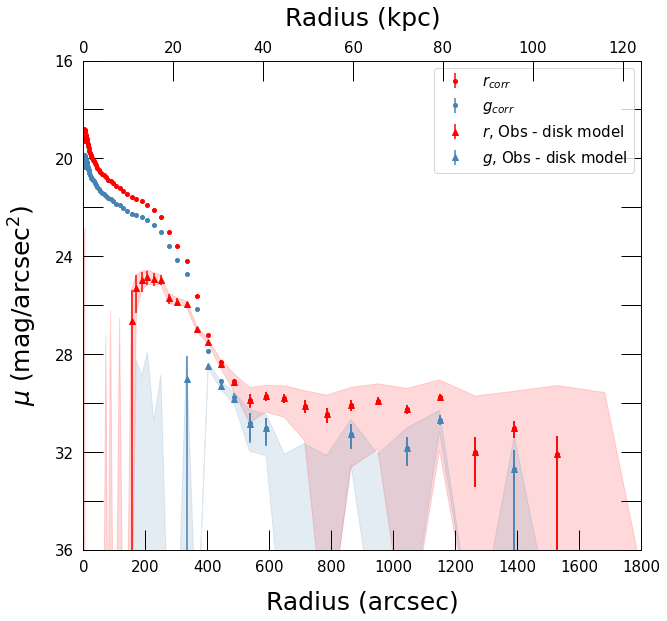

In [59]:
# Comparing scattered light-corrected profiles with these new residual profiles

fig, ax = plt.subplots()

ax.errorbar(rad_r_round*pix_size, SB_r_corr, yerr=SB_err_r_corr, fmt='o', color='r', label='$r_{corr}$', markersize=4)
ax.errorbar(rad_r_round*pix_size, SB_g_corr, yerr=SB_err_g_corr, fmt='o', color='steelblue', label='$g_{corr}$', markersize=4)

ax.errorbar(rad_r_round*pix_size, SB_r_residual, yerr=SB_err_r_residual, fmt='o', marker='^', color='r', label="$r$, Obs - disk model")
ax.errorbar(rad_r_round*pix_size, SB_g_residual, yerr=SB_err_g_residual, fmt='o', marker='^', color='steelblue', label="$g$, Obs - disk model")
ax.fill_between(rad_r_round*pix_size, SB_err_r_residual_ps - extinct_r, SB_err_r_residual_ms - extinct_r, alpha=0.15, color="r")
ax.fill_between(rad_g_round*pix_size, SB_err_g_residual_ps - extinct_g, SB_err_g_residual_ms - extinct_g, alpha=0.15, color="steelblue")


plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 1800)
ax.set_ylim(36, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36"])

fig.set_size_inches(10,9)
plt.show()

In [60]:
# Calculating colour and errors for residual profiles

gmr_residual = SB_g_residual - SB_r_residual

gmr_residual_err = gp.calc_colour_error(quads_g_round.combinedFlux - isophotes_model_g_round.intens, 
                                    flux_g_residual_err, 
                                    quads_r_round.combinedFlux - isophotes_model_round.intens,
                                    flux_r_residual_err, 
                                    0, 
                                    0, 
                                    0, 
                                    0)

gmr_residual_err_sys =  gp.calc_colour_error(quads_g_round.combinedFlux - isophotes_model_g_round.intens, 
                                         flux_r_residual_syserr, 
                                         quads_r_round.combinedFlux - isophotes_model_round.intens, 
                                         flux_r_residual_syserr, 
                                         0, 
                                         0, 
                                         0, 
                                         0)

No handles with labels found to put in legend.


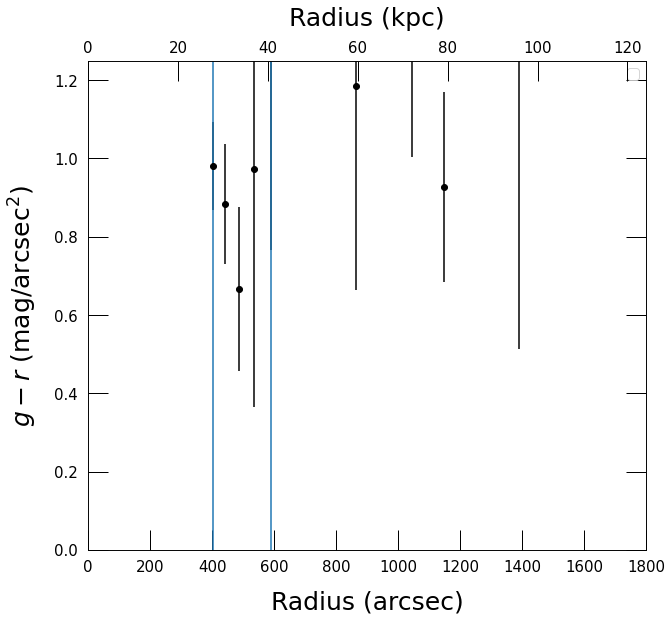

In [61]:
# Plotting residual colour profile and identifying reliable range to measure an average outer colour

colour_avg_range_residual = [400,600]  # in arcsec

# Converting radius range to index range
range_index_residual = [min(range(len(rad_r)), key=lambda x: abs(rad_r[x]-colour_avg_range_residual[0]/2.5)),
                        min(range(len(rad_r)), key=lambda x: abs(rad_r[x]-colour_avg_range_residual[1]/2.5))]

fig, ax = plt.subplots()

ax.errorbar(rad_r_round*pix_size, gmr_residual, yerr=gmr_residual_err, fmt='o', color='k')

# Radial range where fixed outer colour is determined
ax.axvline(x=rad_r[range_index_residual[0]]*pix_size)
ax.axvline(x=rad_r[range_index_residual[1]]*pix_size)

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$g-r$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 1800)
ax.set_ylim(0, 1.25)

fig.set_size_inches(10,9)
plt.show()

(0.0, 12.0)

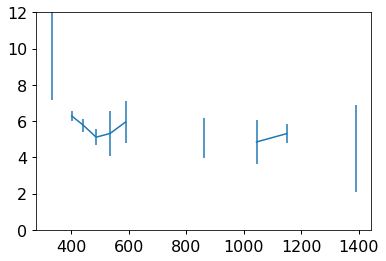

In [62]:
# Surface stellar mass density profile for residual profile, with fixed outer colour

outer_gmr_residual = np.average(gmr_residual[range_index_residual[0]:range_index_residual[1]+1], weights=1/(gmr_corr_err[range_index_residual[0]:range_index_residual[1]+1])**2)

gmr_residual_fixed = np.array([g if i <= range_index_residual[1] else outer_gmr_residual for i,g in enumerate(gmr_residual)])

mass_density_residual_fixed = -0.4*(SB_g_residual - DM - extinct_g)
mass_density_residual_fixed += 2.029*gmr_residual_fixed - 0.984 + 2.044
mass_density_residual_fixed += np.log10(1/(kpc_factor)**2)

dg = 2.5*np.log10(np.e)*flux_g_residual_err/(quads_g_round.combinedFlux - isophotes_model_g_round.intens)
dg_sys = 2.5*np.log10(np.e)*flux_g_residual_syserr/(quads_g_round.combinedFlux - isophotes_model_g_round.intens)

mass_density_residual_err = np.sqrt((0.4*dg)**2 + (2.029*gmr_residual_err)**2 + dCMLR**2)
mass_density_residual_err_sys = np.sqrt((0.4*dg_sys)**2 + (2.029*gmr_residual_err_sys)**2 + dCMLR**2 + dCMLR_sys**2)

plt.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err)
plt.ylim([0,12])

(0.0, 12.0)

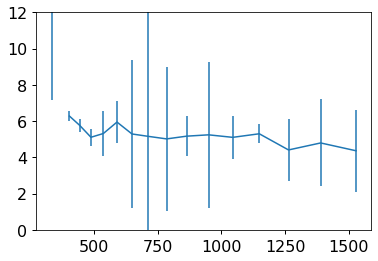

In [63]:
mass_density_residual_fixed2 = -0.4*(SB_r_residual + gmr_residual_fixed - DM - extinct_r)
mass_density_residual_fixed2 += 2.029*gmr_residual_fixed - 0.984 + 2.044
mass_density_residual_fixed2 += np.log10(1/(kpc_factor)**2)

plt.errorbar(rad_r_round*pix_size, mass_density_residual_fixed2, yerr=mass_density_residual_err)
plt.ylim([0,12])

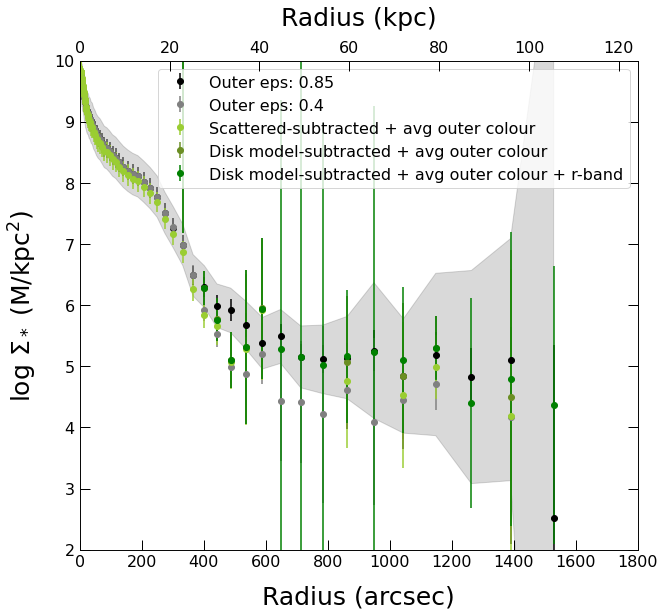

In [64]:
# Comparing scattered light-subtracted mass density profile with residual mass density profile
# The uncorrected profile (no rounded isophotes, no scattered light correction) and the rounded
# profile without scattered light correction are also included for comparison 

fig, ax = plt.subplots()

# Default mass density profile
ax.errorbar(rad_r*pix_size, mass_density, yerr=mass_density_err, fmt='o', c="k", label="Outer eps: 0.85")
plt.fill_between(rad_r*pix_size, mass_density - mass_density_err_sys, mass_density + mass_density_err_sys, alpha=0.15, color="k")

#ax.errorbar(rad_r_round*pix_size, mass_density_round, yerr=mass_density_round_err, c="green", label="Outer eps: 0.2")
ax.errorbar(rad_r_round*pix_size, mass_density_round_fixed, yerr=mass_density_round_err, fmt='o', c="grey", label="Outer eps: 0.4")
#ax.errorbar(rad_r_round*pix_size, mass_density_round_fixed2, yerr=mass_density_round_err, c="olivedrab", label="Avg outer colour + outer eps: 0.2 + r-band")

ax.errorbar(rad_r_round*pix_size, mass_density_corr_fixed, yerr=mass_density_corr_err, fmt='o', c="yellowgreen", label="Scattered-subtracted + avg outer colour")
ax.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err, fmt='o', c="olivedrab", label="Disk model-subtracted + avg outer colour")
ax.errorbar(rad_r_round*pix_size, mass_density_residual_fixed2, yerr=mass_density_residual_err, fmt='o', c="green", label="Disk model-subtracted + avg outer colour + r-band")

##plt.fill_between(rad_r_round*pix_size, mass_density_corr - mass_density_corr_err_sys, mass_density_corr + mass_density_corr_err_sys, alpha=0.15, color="green")

plt.gca().invert_yaxis()

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend(loc=1)

ax.set_xlim(0, 1800)
ax.set_ylim(2, 10)

fig.set_size_inches(10, 9)
plt.show()

### Fitting surface mass density residual profile

Some existing work has characterized stellar halos by their power law slope. We fit the outer profile with a power law and use emcee to sample the posterior probability distribution and assess 1-sigma uncertainties for the parameters. (This tutorial was very helpful: https://emcee.readthedocs.io/en/stable/tutorials/line/)

Several different definitions for the beginning of the halo-dominated region can be imagined, and so we perform the fits (and later calculate mass fractions) using four different definitions. These will all be tabulated and will facilitate comparisons with a broad range of work.

In [65]:
def model_broken_exp(theta, x):
    
    a0, h1, h2, rbreak = theta
    b0 = a0 + rbreak*(1/h2 - 1/h1)*np.log10(np.e)
    
    model = np.zeros(x.shape)
    model += (x <= rbreak)*(a0 - x/h1*np.log10(np.e))
    model += (x > rbreak)*(b0 - x/h2*np.log10(np.e))   
    return model

def model_powerlaw(theta, x):
    
    a0, k = theta
    return a0 - k*np.log10(x)

In [66]:
# Possible radii limits for stellar halo measurements:

# >5 scale radii (from Imfit model)
halofit_min_0 = next(i for i, r in enumerate(rad_r_round*pix_size) if r >= 237.9)

# >20 kpc
halofit_min_1 = next(i for i, r in enumerate(rad_r_round*pix_size) if r >= 20./kpc_factor)

# Surface mass density < 10^6 M*/kpc^2
halofit_min_2 = next(i for i, s in enumerate(mass_density_corr_fixed2) if s <= 6.)

# >5 half-mass radii
# This one is a little more complicated
areas_round = gp.get_iso_areas(isophotes_r_round, image_r_sub)  
areas_kpc2 = areas_round*(kpc_factor*pix_size)**2     # Will need this for later integrations

Mtot, err_Mtot = gp.integrate_profile(mass_density_corr_fixed2, areas_kpc2, mass_density_corr_err, 0.7*kpc_factor*pix_size)

halofit_min_3 = None
for i in range(1, len(mass_density_corr_fixed)):
    tmp_mass, _ = gp.integrate_profile(mass_density_corr_fixed2[:i], areas_kpc2[:i], mass_density_corr_err[:i], 0.7*kpc_factor*pix_size)
    
    # Half mass radius identified!
    if Mtot - tmp_mass <= np.log10(2):
        R_half = rad_r_round[i] # in pixel units
        halofit_min_3 = next(j for j, r in enumerate(rad_r_round) if r >= 5*R_half)
        break

# Common maximum radius (just where the profile ends)
halofit_max = next(i for i, r in enumerate(rad_r_round*pix_size) if r > 1600)

In [67]:
def loglike(theta, x, y, yerr):
    
    model = model_powerlaw(theta, x)
    return -0.5*np.sum((y - model)**2/yerr**2)

logl = lambda *args: -loglike(*args)

# Initial parameters and input to fit
initial = np.array([8, 3])
temp_i = [i for i, (val, err) in enumerate(zip(mass_density_residual_fixed, mass_density_residual_err)) if np.isfinite(val) and np.isfinite(err)]
indices_0 = [i for i in temp_i if i >= halofit_min_0 and i <= halofit_max]
indices_1 = [i for i in temp_i if i >= halofit_min_1 and i <= halofit_max]
indices_2 = [i for i in temp_i if i >= halofit_min_2 and i <= halofit_max]
indices_3 = [i for i in temp_i if i >= halofit_min_3 and i <= halofit_max]

x_0 = rad_r_round[indices_0]*pix_size
y_0 = mass_density_residual_fixed2[indices_0]
yerr_0 = mass_density_residual_err[indices_0]

x_1 = rad_r_round[indices_1]*pix_size
y_1 = mass_density_residual_fixed2[indices_1]
yerr_1 = mass_density_residual_err[indices_1]

x_2 = rad_r_round[indices_2]*pix_size
y_2 = mass_density_residual_fixed2[indices_2]
yerr_2 = mass_density_residual_err[indices_2]

x_3 = rad_r_round[indices_3]*pix_size
y_3 = mass_density_residual_fixed2[indices_3]
yerr_3 = mass_density_residual_err[indices_3]

# Doing the fit!
result_0 = minimize(logl, initial, args=(x_0, y_0, yerr_0))
result_1 = minimize(logl, initial, args=(x_1, y_1, yerr_1))
result_2 = minimize(logl, initial, args=(x_2, y_2, yerr_2))
result_3 = minimize(logl, initial, args=(x_3, y_3, yerr_3))

Fit to r > 5Rd [11.50012744  2.10922821]
Fit to r > 20 kpc [11.50012744  2.10922821]
Fit to r where surface mass density < 10^6 [11.21359839  2.00813203]
Fit to r > 5Rh [11.21359839  2.00813203]


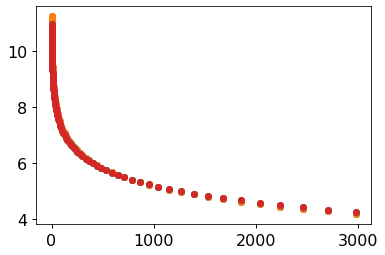

In [68]:
# Creating model profiles for each fit and quickly plotting them together
# Maximum likelihood parameters are also printed to screen

mass_density_fitted_0 = model_powerlaw(result_0.x, rad_r_round*pix_size)
mass_density_fitted_1 = model_powerlaw(result_1.x, rad_r_round*pix_size)
mass_density_fitted_2 = model_powerlaw(result_2.x, rad_r_round*pix_size)
mass_density_fitted_3 = model_powerlaw(result_3.x, rad_r_round*pix_size)

plt.scatter(rad_r_round*pix_size, mass_density_fitted_0)
plt.scatter(rad_r_round*pix_size, mass_density_fitted_1)
plt.scatter(rad_r_round*pix_size, mass_density_fitted_2)
plt.scatter(rad_r_round*pix_size, mass_density_fitted_3)

print("Fit to r > 5Rd", result_0.x)
print("Fit to r > 20 kpc", result_1.x)
print("Fit to r where surface mass density < 10^6", result_2.x)
print("Fit to r > 5Rh", result_3.x)

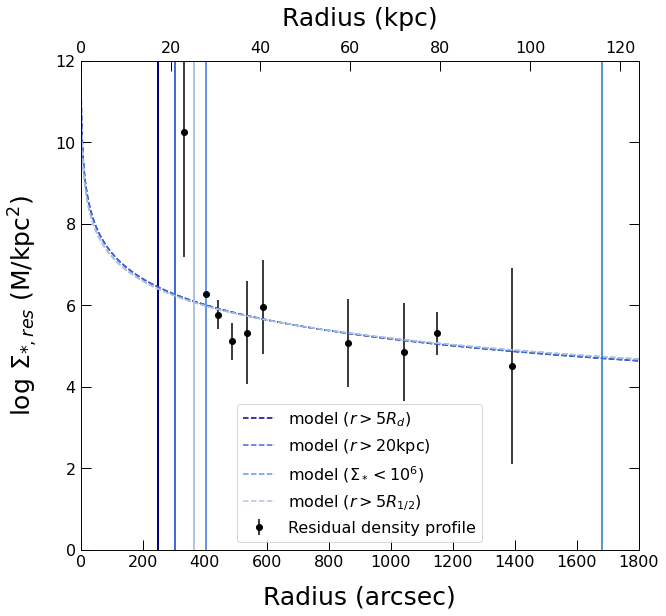

In [69]:
# Nicer plot with the four models and the residual mass density profile

fig, ax = plt.subplots()

# Mass density profile with round(er) outer isophotes
ax.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err, fmt='o', c="k", label="Residual density profile")

##plt.fill_between(rad_r_round*pix_size, mass_density_residuals - mass_density_round_err_sys, mass_density_residuals + mass_density_round_err_sys, alpha=0.15, color="green")

plt.plot(rad_r_round*pix_size, mass_density_fitted_0, '--', color='navy', label="model ($r>5R_d$)")
plt.axvline(x=rad_r_round[halofit_min_0]*pix_size, color='navy', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_1, '--', color='royalblue', label="model ($r>20$kpc)")
plt.axvline(x=rad_r_round[halofit_min_1]*pix_size, color='royalblue', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_2, '--', color='cornflowerblue', label="model ($\Sigma_*<10^6$)")
plt.axvline(x=rad_r_round[halofit_min_2]*pix_size, color='cornflowerblue', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_3, '--', color='lightsteelblue', label="model ($r>5R_{1/2}$)")
plt.axvline(x=rad_r_round[halofit_min_3]*pix_size, color='lightsteelblue', lw=2)

plt.axvline(x=rad_r_round[halofit_max]*pix_size)

plt.gca().invert_yaxis()

ax.set_ylabel(r"log $\Sigma_{*, res}$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend()

ax.set_xlim(0, 1800)
ax.set_ylim(0, 12)

fig.set_size_inches(10, 9)
plt.show()

In [70]:
# MCMC with emcee 

# Uninformative prior (not normalized but that's fine)
def log_prior(theta):
    a0, k = theta
    if 0 < a0 < 30 and 0 < k < 8:
        return 0.0
    return -np.inf

def log_prob(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta, x, y, yerr)

pos_0 = result_0.x + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos_0.shape
sampler_0 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_0, y_0, yerr_0))
sampler_0.run_mcmc(pos_0, 5000)

pos_1 = result_1.x + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos_1.shape
sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_1, y_1, yerr_1))
sampler_1.run_mcmc(pos_1, 5000)

pos_2 = result_2.x + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos_2.shape
sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_2, y_2, yerr_2))
sampler_2.run_mcmc(pos_2, 5000)

pos_3 = result_3.x + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos_3.shape
sampler_3 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_3, y_3, yerr_3))
sampler_3.run_mcmc(pos_3, 5000)

State([[10.23350333  1.59085703]
 [14.3738641   3.19237141]
 [16.25056498  3.88831255]
 [16.09685059  3.8607111 ]
 [14.47238774  3.19444734]
 [10.8123016   1.94555154]
 [10.52190505  1.67110112]
 [11.21411562  1.96075638]
 [ 7.592069    0.49122712]
 [11.87600167  2.39621812]
 [ 8.85993135  1.13719279]
 [ 7.83928204  0.72142224]
 [12.03516661  2.33369582]
 [14.18093991  3.10206181]
 [10.81893267  1.8308529 ]
 [12.77343971  2.5788045 ]
 [13.26947126  2.76958313]
 [10.78052326  1.97098781]
 [15.0597298   3.4467983 ]
 [12.56453007  2.35652923]
 [12.17759424  2.34765134]
 [10.91909799  1.88876281]
 [14.243551    3.09031633]
 [11.49649475  2.11353691]
 [15.16200092  3.50214643]
 [ 8.57477918  1.06800946]
 [16.26088848  3.89447411]
 [16.56738689  4.01647879]
 [13.07800143  2.73122447]
 [10.08708993  1.48224907]
 [ 7.37745686  0.62544232]
 [14.52032602  3.24256026]], log_prob=[-2.46998512 -2.6150575  -3.45230879 -3.64018899 -2.62863197 -2.92640703
 -2.87845191 -2.31291582 -6.73812976 -4.562576

In [71]:
# Checking timescale on which samples in chains are related

print(sampler_0.get_autocorr_time())
print(sampler_1.get_autocorr_time())
print(sampler_2.get_autocorr_time())
print(sampler_3.get_autocorr_time())

[32.31197047 32.14990871]
[30.59509155 30.44840018]
[31.76807561 31.67475283]
[29.57841965 29.57492896]


In [72]:
# Discarding a few hundred samples and thinning by about half of the autocorrelation time

flat_samples_0 = sampler_0.get_chain(discard=200, thin=20, flat=True)
flat_samples_1 = sampler_1.get_chain(discard=200, thin=20, flat=True)
flat_samples_2 = sampler_2.get_chain(discard=200, thin=20, flat=True)
flat_samples_3 = sampler_3.get_chain(discard=200, thin=20, flat=True)

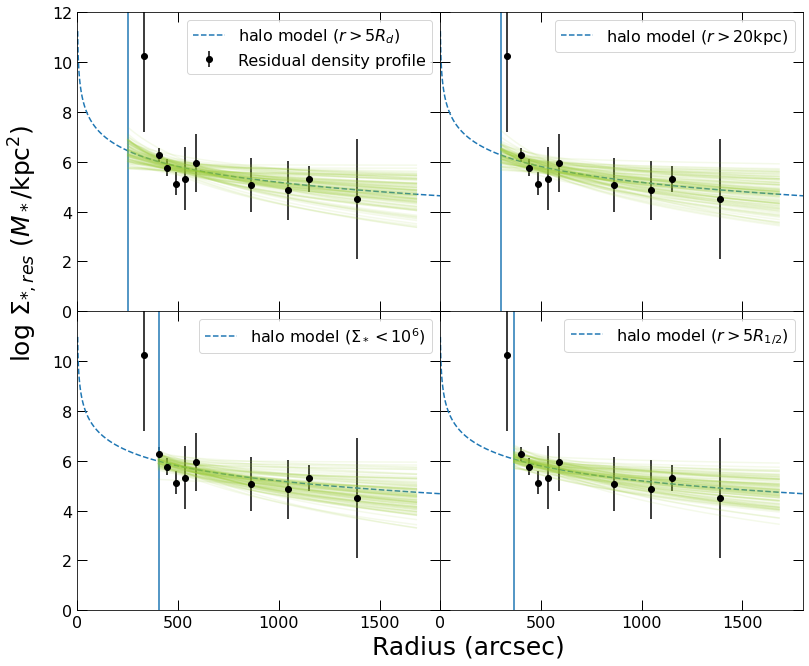

In [73]:
# Plotting each model with 100 randomly selected samples

fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.0, hspace=0.0)
ax0, ax1, ax2, ax3 = ax.flatten()

ax0.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err, fmt='o', c="k", label="Residual density profile")
ax0.plot(rad_r_round*pix_size, mass_density_fitted_0, '--', label="halo model ($r>5R_d$)")
ax0.axvline(x=rad_r_round[halofit_min_0]*pix_size)

inds = np.random.randint(len(flat_samples_0), size=100)
model_x0 = np.linspace(rad_r_round[halofit_min_0]*pix_size, rad_r_round[halofit_max]*pix_size, 1000)
for ind in inds:
    sample = flat_samples_0[ind]
    ax0.plot(model_x0, model_powerlaw(sample, model_x0), color="yellowgreen", alpha=0.1)
    
ax1.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err, fmt='o', c="k")
ax1.plot(rad_r_round*pix_size, mass_density_fitted_1, '--', label="halo model ($r>20$kpc)")
ax1.axvline(x=rad_r_round[halofit_min_1]*pix_size)

inds = np.random.randint(len(flat_samples_1), size=100)
model_x1 = np.linspace(rad_r_round[halofit_min_1]*pix_size, rad_r_round[halofit_max]*pix_size, 1000)
for ind in inds:
    sample = flat_samples_1[ind]
    ax1.plot(model_x1, model_powerlaw(sample, model_x1), color="yellowgreen", alpha=0.1)
    
ax2.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err, fmt='o', c="k")
ax2.plot(rad_r_round*pix_size, mass_density_fitted_2, '--', label="halo model ($\Sigma_*<10^6$)")
ax2.axvline(x=rad_r_round[halofit_min_2]*pix_size)

inds = np.random.randint(len(flat_samples_2), size=100)
model_x2 = np.linspace(rad_r_round[halofit_min_2]*pix_size, rad_r_round[halofit_max]*pix_size, 1000)
for ind in inds:
    sample = flat_samples_2[ind]
    ax2.plot(model_x2, model_powerlaw(sample, model_x2), color="yellowgreen", alpha=0.1)
    
ax3.errorbar(rad_r_round*pix_size, mass_density_residual_fixed, yerr=mass_density_residual_err, fmt='o', c="k")
ax3.plot(rad_r_round*pix_size, mass_density_fitted_3, '--', label="halo model ($r>5R_{1/2}$)")
ax3.axvline(x=rad_r_round[halofit_min_3]*pix_size)

inds = np.random.randint(len(flat_samples_3), size=100)
model_x3 = np.linspace(rad_r_round[halofit_min_3]*pix_size, rad_r_round[halofit_max]*pix_size, 1000)
for ind in inds:
    sample = flat_samples_3[ind]
    ax3.plot(model_x3, model_powerlaw(sample, model_x3), color="yellowgreen", alpha=0.1)
    

for a in ax0, ax1, ax2, ax3:
    a.legend()
    a.set_xlim(0,1800)
    a.set_ylim(0, 12)
    a.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
    a.tick_params(axis='both',which='major',direction='in')
 
ax0.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax3.set_yticklabels([])

ax2.set_yticklabels(["0", "2", "4", "6", "8", "10", ""])
ax2.set_xticklabels(["0", "500", "1000", "1500", ""])

fig.text(0.44, 0.07, "Radius (arcsec)", size=25)
fig.text(0.05, 0.45, r"log $\Sigma_{*,res}$ ($M_*$/kpc$^2$)", size=25, rotation=90)

fig.set_size_inches(13, 11)

In [74]:
# Median param values (aka 50th percentile) with 1 sigma uncertainties (16th and 84th percentiles)

from IPython.display import display, Math

labels=['a0', 'k']

print("halo model (r > 5R_d)")
for i in range(2):
    mcmc = np.percentile(flat_samples_0[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
print("\nhalo model (r > 20 kpc)")
for i in range(2):
    mcmc = np.percentile(flat_samples_1[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
print("\nhalo model (Sigma_* < 10^6)")
for i in range(2):
    mcmc = np.percentile(flat_samples_2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))    
    
print("\nhalo model (r > 5R_{1/2})")
for i in range(2):
    mcmc = np.percentile(flat_samples_3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))  

halo model (r > 5R_d)


<IPython.core.display.Math object>

<IPython.core.display.Math object>


halo model (r > 20 kpc)


<IPython.core.display.Math object>

<IPython.core.display.Math object>


halo model (Sigma_* < 10^6)


<IPython.core.display.Math object>

<IPython.core.display.Math object>


halo model (r > 5R_{1/2})


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Compare with fit to scattered light-corrected profile

Repeating the above fits using the scattered light-corrected surface stellar mass density profile instead of the residual profile. Power law index $k$ is significantly larger

In [75]:
x_0c = rad_r_round[indices_0]*pix_size
y_0c = mass_density_corr_fixed2[indices_0]
yerr_0c = mass_density_corr_err[indices_0]

x_1c = rad_r_round[indices_1]*pix_size
y_1c = mass_density_corr_fixed2[indices_1]
yerr_1c = mass_density_corr_err[indices_1]

x_2c = rad_r_round[indices_2]*pix_size
y_2c = mass_density_corr_fixed2[indices_2]
yerr_2c = mass_density_corr_err[indices_2]

x_3c = rad_r_round[indices_3]*pix_size
y_3c = mass_density_corr_fixed2[indices_3]
yerr_3c = mass_density_corr_err[indices_3]

# Doing the fit!
result_0c = minimize(logl, initial, args=(x_0c, y_0c, yerr_0c))
result_1c = minimize(logl, initial, args=(x_1c, y_1c, yerr_1c))
result_2c = minimize(logl, initial, args=(x_2c, y_2c, yerr_2c))
result_3c = minimize(logl, initial, args=(x_3c, y_3c, yerr_3c))

Results for fits without subtracting disk model:
Fit to r > 5Rd [16.85291162  4.09368587]
Fit to r > 20 kpc [16.85291162  4.09368587]
Fit to r where surface mass density < 10^6 [10.69629771  1.90003593]
Fit to r > 5Rh [10.69629771  1.90003593]


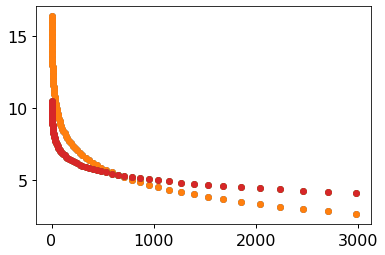

In [76]:
mass_density_fitted_0c = model_powerlaw(result_0c.x, rad_r_round*pix_size)
mass_density_fitted_1c = model_powerlaw(result_1c.x, rad_r_round*pix_size)
mass_density_fitted_2c = model_powerlaw(result_2c.x, rad_r_round*pix_size)
mass_density_fitted_3c = model_powerlaw(result_3c.x, rad_r_round*pix_size)

plt.scatter(rad_r_round*pix_size, mass_density_fitted_0c)
plt.scatter(rad_r_round*pix_size, mass_density_fitted_1c)
plt.scatter(rad_r_round*pix_size, mass_density_fitted_2c)
plt.scatter(rad_r_round*pix_size, mass_density_fitted_3c)

print("Results for fits without subtracting disk model:")
print("Fit to r > 5Rd", result_0c.x)
print("Fit to r > 20 kpc", result_1c.x)
print("Fit to r where surface mass density < 10^6", result_2c.x)
print("Fit to r > 5Rh", result_3c.x)

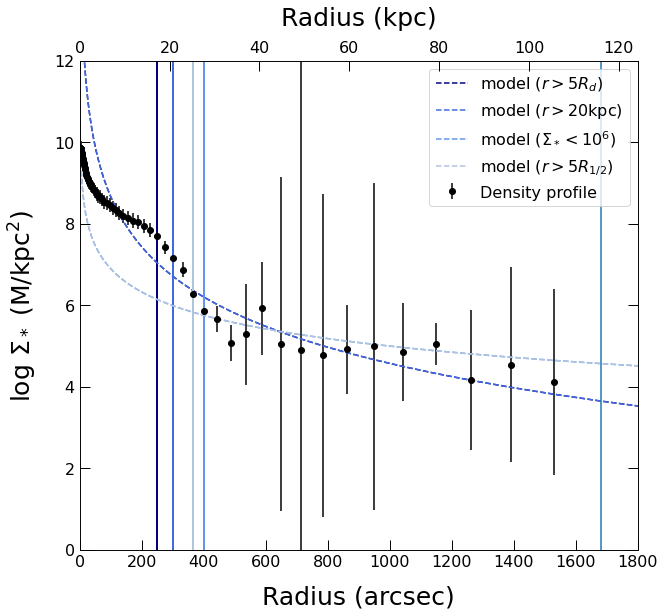

In [77]:
fig, ax = plt.subplots()

# Mass density profile with round(er) outer isophotes
ax.errorbar(rad_r_round*pix_size, mass_density_corr_fixed2, yerr=mass_density_corr_err, fmt='o', c="k", label="Density profile")

##plt.fill_between(rad_r_round*pix_size, mass_density_residuals - mass_density_round_err_sys, mass_density_residuals + mass_density_round_err_sys, alpha=0.15, color="green")

plt.plot(rad_r_round*pix_size, mass_density_fitted_0c, '--', color='navy', label="model ($r>5R_d$)")
plt.axvline(x=rad_r_round[halofit_min_0]*pix_size, color='navy', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_1c, '--', color='royalblue', label="model ($r>20$kpc)")
plt.axvline(x=rad_r_round[halofit_min_1]*pix_size, color='royalblue', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_2c, '--', color='cornflowerblue', label="model ($\Sigma_*<10^6$)")
plt.axvline(x=rad_r_round[halofit_min_2]*pix_size, color='cornflowerblue', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_3c, '--', color='lightsteelblue', label="model ($r>5R_{1/2}$)")
plt.axvline(x=rad_r_round[halofit_min_3]*pix_size, color='lightsteelblue', lw=2)

plt.axvline(x=rad_r_round[halofit_max]*pix_size)

plt.gca().invert_yaxis()

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend(loc=1)

ax.set_xlim(0, 1800)
ax.set_ylim(0, 12)

fig.set_size_inches(10, 9)
plt.show()

### Fitting disk in scattered light-corrected profile

In [78]:
# Disk fitting indices

# Not fitting inner 1 kpc
diskfit_min = next(i for i, r in enumerate(rad_r_round*pix_size) if r >= 1/kpc_factor)

# Fitting out to visual edge of galaxy
diskfit_max = next(i for i, r in enumerate(rad_r_round*pix_size) if r >= 390)

temp_i = [i for i, (val, err) in enumerate(zip(mass_density_corr_fixed2, mass_density_corr_err)) if np.isfinite(val) and np.isfinite(err)]
indices_disk = [i for i in temp_i if i >= diskfit_min and i <= diskfit_max]

x_disk = rad_r_round[indices_disk]*pix_size
y_disk = mass_density_corr_fixed2[indices_disk]
yerr_disk = mass_density_corr_err[indices_disk]

In [79]:
def loglike(theta, x, y, yerr):
    
    model = model_broken_exp(theta, x)
    return -0.5*np.sum((y - model)**2/yerr**2)

logl = lambda *args: -loglike(*args)

# Doing the fit!
initial_disk = [9, 60, 20, 250]
result_disk = minimize(logl, initial_disk, args=(x_disk, y_disk, yerr_disk))

Broken exponential fit to disk [  9.19203705  66.47375494  31.96301742 300.67373408]


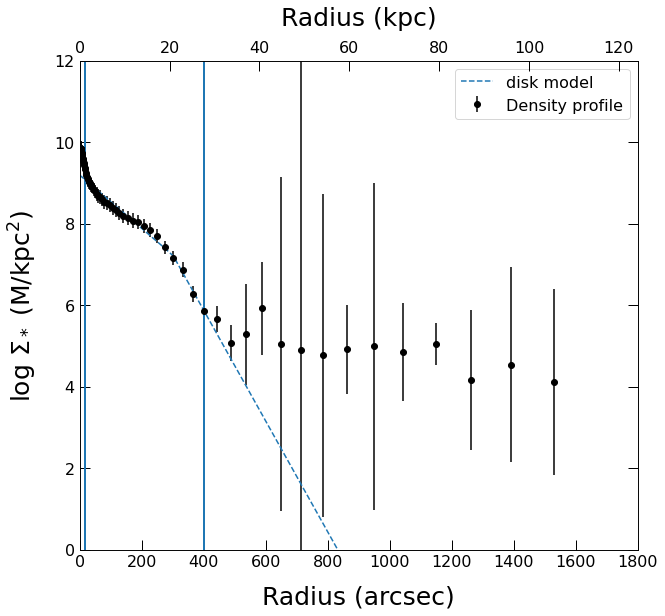

In [80]:
mass_density_fitted_disk = model_broken_exp(result_disk.x, rad_r_round*pix_size)

print("Broken exponential fit to disk", result_disk.x)

fig, ax = plt.subplots()

# Mass density profile with round(er) outer isophotes
ax.errorbar(rad_r_round*pix_size, mass_density_corr_fixed2, yerr=mass_density_corr_err, fmt='o', c="k", label="Density profile")

plt.plot(rad_r_round*pix_size, mass_density_fitted_disk, '--', label="disk model")
plt.axvline(x=rad_r_round[diskfit_min]*pix_size, lw=2)
plt.axvline(x=rad_r_round[diskfit_max]*pix_size, lw=2)

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend()

ax.set_xlim(0, 1800)
ax.set_ylim(0, 12)

fig.set_size_inches(10, 9)
plt.show()

In [81]:
# Now fitting power law to outer region + previously fitted disk

initial = np.array([8, 3])
temp_i = [i for i, (val, err) in enumerate(zip(mass_density_corr_fixed, mass_density_corr_err)) if np.isfinite(val) and np.isfinite(err)]
indices_0 = [i for i in temp_i if i >= halofit_min_0 and i <= halofit_max]
indices_1 = [i for i in temp_i if i >= halofit_min_1 and i <= halofit_max]
indices_2 = [i for i in temp_i if i >= halofit_min_2 and i <= halofit_max]
indices_3 = [i for i in temp_i if i >= halofit_min_3 and i <= halofit_max]

x_0c = rad_r_round[indices_0]*pix_size
y_0c = mass_density_corr_fixed2[indices_0]
yerr_0c = mass_density_corr_err[indices_0]

x_1c = rad_r_round[indices_1]*pix_size
y_1c = mass_density_corr_fixed2[indices_1]
yerr_1c = mass_density_corr_err[indices_1]

x_2c = rad_r_round[indices_2]*pix_size
y_2c = mass_density_corr_fixed2[indices_2]
yerr_2c = mass_density_corr_err[indices_2]

x_3c = rad_r_round[indices_3]*pix_size
y_3c = mass_density_corr_fixed2[indices_3]
yerr_3c = mass_density_corr_err[indices_3]

In [82]:
def loglike(theta, x, y, yerr):
    
    model = np.power(10,model_broken_exp(result_disk.x, x))
    model += np.power(10, model_powerlaw(theta, x))
    model = np.log10(model)
    return -0.5*np.sum((y - model)**2/yerr**2)

logl = lambda *args: -loglike(*args)

# Doing the fit!
result_0dh = minimize(logl, initial, args=(x_0c, y_0c, yerr_0c))
result_1dh = minimize(logl, initial, args=(x_1c, y_1c, yerr_1c))
result_2dh = minimize(logl, initial, args=(x_2c, y_2c, yerr_2c))
result_3dh = minimize(logl, initial, args=(x_3c, y_3c, yerr_3c))

In [83]:
mass_density_fitted_0h = model_powerlaw(result_0dh.x, rad_r_round*pix_size)
mass_density_fitted_1h = model_powerlaw(result_1dh.x, rad_r_round*pix_size)
mass_density_fitted_2h = model_powerlaw(result_2dh.x, rad_r_round*pix_size)
mass_density_fitted_3h = model_powerlaw(result_3dh.x, rad_r_round*pix_size)

print("Results for halo fits after fitting disk model:")
print("Fit to r > 5Rd", result_0dh.x, "(compared to", result_0c.x, ")")
print("Fit to r > 20 kpc", result_1dh.x, "(compared to", result_1c.x, ")")
print("Fit to r where surface mass density < 10^6", result_2dh.x, "(compared to", result_2c.x, ")")
print("Fit to r > 5Rh", result_3dh.x, "(compared to", result_3c.x, ")")

Results for halo fits after fitting disk model:
Fit to r > 5Rd [6.01576531 0.32736356] (compared to [16.85291162  4.09368587] )
Fit to r > 20 kpc [5.9423025  0.30217398] (compared to [16.85291162  4.09368587] )
Fit to r where surface mass density < 10^6 [6.1270863  0.36441584] (compared to [10.69629771  1.90003593] )
Fit to r > 5Rh [5.85705037 0.27330669] (compared to [10.69629771  1.90003593] )


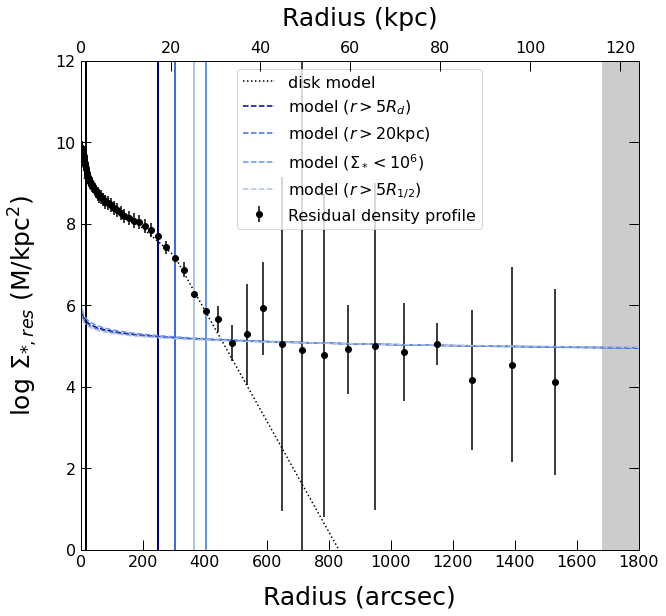

In [84]:
# Nicer plot with the four models and the residual mass density profile

fig, ax = plt.subplots()

# Mass density profile with round(er) outer isophotes
ax.errorbar(rad_r_round*pix_size, mass_density_corr_fixed2, yerr=mass_density_corr_err, fmt='o', c="k", label="Residual density profile")

plt.plot(rad_r_round*pix_size, mass_density_fitted_disk, 'k:', label="disk model")
plt.axvline(x=rad_r_round[diskfit_min]*pix_size, color='k', lw=2)
plt.axvline(x=rad_r_round[diskfit_max]*pix_size, color='k', lw=2)

##plt.fill_between(rad_r_round*pix_size, mass_density_residuals - mass_density_round_err_sys, mass_density_residuals + mass_density_round_err_sys, alpha=0.15, color="green")

plt.plot(rad_r_round*pix_size, mass_density_fitted_0h, '--', color='navy', label="model ($r>5R_d$)")
plt.axvline(x=rad_r_round[halofit_min_0]*pix_size, color='navy', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_1h, '--', color='royalblue', label="model ($r>20$kpc)")
plt.axvline(x=rad_r_round[halofit_min_1]*pix_size, color='royalblue', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_2h, '--', color='cornflowerblue', label="model ($\Sigma_*<10^6$)")
plt.axvline(x=rad_r_round[halofit_min_2]*pix_size, color='cornflowerblue', lw=2)
plt.plot(rad_r_round*pix_size, mass_density_fitted_3h, '--', color='lightsteelblue', label="model ($r>5R_{1/2}$)")
plt.axvline(x=rad_r_round[halofit_min_3]*pix_size, color='lightsteelblue', lw=2)

rejected_outer = patches.Rectangle((rad_r_round[halofit_max]*pix_size, 0), (1800-rad_r_round[halofit_max]*pix_size), 12, edgecolor=None, facecolor='k', alpha=0.2)
ax.add_patch(rejected_outer)

plt.gca().invert_yaxis()

ax.set_ylabel(r"log $\Sigma_{*, res}$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*1800) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend()

ax.set_xlim(0, 1800)
ax.set_ylim(0, 12)

fig.set_size_inches(10, 9)
plt.show()

## Integral of mass density profiles and mass fractions

In [85]:
# Integrating scattered light-corrected profile everywhere 
M_total, err_M_total = gp.integrate_profile(mass_density_corr_fixed2[:halofit_max], areas_kpc2[:halofit_max], mass_density_corr_err[:halofit_max], 0.7*kpc_factor*pix_size)
M_total, err_M_total_sys = gp.integrate_profile(mass_density_corr_fixed2[:halofit_max], areas_kpc2[:halofit_max], mass_density_corr_err_sys[:halofit_max], 0.7*kpc_factor*pix_size)

print(f"Log total stellar mass: {M_total:.2f} +/- {err_M_total:.2f} (sys: +/- {err_M_total_sys:.2f})")

Log total stellar mass: 10.51 +/- 0.09 (sys: +/- 0.28)


In [86]:
print("Integrating residual profile in halo fit regions ...")

M_halo_0, err_M_halo_0 = gp.integrate_profile(mass_density_residual_fixed[halofit_min_0:halofit_max], areas_kpc2[halofit_min_0:halofit_max], mass_density_residual_err[halofit_min_0:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_0 = M_halo_0 - M_total
err_f_halo_0 = np.sqrt(err_M_halo_0**2 + err_M_total**2)
print(f"Log mass beyond 5 Rd: {M_halo_0:.2f} +/- {err_M_halo_0:.2f} (frac: {f_halo_0:.2f} +/- {err_f_halo_0:.2f})")

M_halo_1, err_M_halo_1 = gp.integrate_profile(mass_density_residual_fixed[halofit_min_1:halofit_max], areas_kpc2[halofit_min_1:halofit_max], mass_density_residual_err[halofit_min_1:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_1 = M_halo_1 - M_total
err_f_halo_1 = np.sqrt(err_M_halo_1**2 + err_M_total**2)
print(f"Log mass beyond 20 kpc: {M_halo_1:.2f} +/- {err_M_halo_1:.2f} (frac: {f_halo_1:.2f} +/- {err_f_halo_1:.2f})")

M_halo_2, err_M_halo_2 = gp.integrate_profile(mass_density_residual_fixed[halofit_min_2:halofit_max], areas_kpc2[halofit_min_2:halofit_max], mass_density_residual_err[halofit_min_2:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_2 = M_halo_2 - M_total
err_f_halo_2 = np.sqrt(err_M_halo_2**2 + err_M_total**2)
print(f"Log mass below 10^6 M*/kpc^2: {M_halo_2:.2f} +/- {err_M_halo_2:.2f} (frac: {f_halo_2:.2f} +/- {err_f_halo_2:.2f})")

M_halo_3, err_M_halo_3 = gp.integrate_profile(mass_density_residual_fixed[halofit_min_3:halofit_max], areas_kpc2[halofit_min_3:halofit_max], mass_density_residual_err[halofit_min_3:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_3 = M_halo_3 - M_total
err_f_halo_3 = np.sqrt(err_M_halo_3**2 + err_M_total**2)
print(f"Log mass beyond 5 Rh: {M_halo_3:.2f} +/- {err_M_halo_3:.2f} (frac: {f_halo_3:.2f} +/- {err_f_halo_3:.2f})")

Integrating residual profile in halo fit regions ...
Log mass beyond 5 Rd: 11.88 +/- 3.07 (frac: 1.37 +/- 3.07)
Log mass beyond 20 kpc: 11.88 +/- 3.07 (frac: 1.37 +/- 3.07)
Log mass below 10^6 M*/kpc^2: 9.31 +/- 0.39 (frac: -1.20 +/- 0.40)
Log mass beyond 5 Rh: 9.31 +/- 0.39 (frac: -1.20 +/- 0.40)


In [87]:
print("Integrating residual profile where positive ...")

M_halo_tot, err_M_halo_tot = gp.integrate_profile(mass_density_residual_fixed, areas_kpc2, mass_density_residual_err, 0.7*kpc_factor*pix_size)
f_halo_tot = M_halo_tot - M_total
err_f_halo_tot = np.sqrt(err_M_halo_tot**2 + err_M_total**2)
print(f"Log total [positive] mass in residual profile: {M_halo_tot:.2f} +/- {err_M_halo_tot:.2f} (frac: {f_halo_tot:.2f} +/- {err_f_halo_tot:.2f})")

Integrating residual profile where positive ...
Log total [positive] mass in residual profile: 11.88 +/- 3.07 (frac: 1.37 +/- 3.07)


In [88]:
print("Integrating scattered light-subtracted profile in halo fit regions ...")

M_halo_0c, err_M_halo_0c = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_0:halofit_max], areas_kpc2[halofit_min_0:halofit_max], mass_density_corr_err[halofit_min_0:halofit_max], 0.7*kpc_factor*pix_size)
_, err_M_halo_0c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_0:halofit_max], areas_kpc2[halofit_min_0:halofit_max], mass_density_corr_err_sys[halofit_min_0:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_0c = M_halo_0c - M_total
err_f_halo_0c = np.sqrt(err_M_halo_0c**2 + err_M_total**2)
err_f_halo_0c_sys = np.sqrt(err_M_halo_0c_sys**2 + err_M_total_sys**2)
print(f"Log mass beyond 5 Rd: {M_halo_0c:.2f} +/- {err_M_halo_0c:.2f} (sys: +/- {err_M_halo_0c_sys:.2f}) (frac: {f_halo_0c:.2f} +/- {err_f_halo_0c:.2f} (sys: +/- {err_f_halo_0c_sys:.2f}))")

M_halo_1c, err_M_halo_1c = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_1:halofit_max], areas_kpc2[halofit_min_1:halofit_max], mass_density_corr_err[halofit_min_1:halofit_max], 0.7*kpc_factor*pix_size)
_, err_M_halo_1c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_1:halofit_max], areas_kpc2[halofit_min_1:halofit_max], mass_density_corr_err_sys[halofit_min_1:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_1c = M_halo_1c - M_total
err_f_halo_1c = np.sqrt(err_M_halo_1c**2 + err_M_total**2)
err_f_halo_1c_sys = np.sqrt(err_M_halo_1c_sys**2 + err_M_total_sys**2)
print(f"Log mass beyond 20 kpc: {M_halo_1c:.2f} +/- {err_M_halo_1c:.2f} (sys: +/- {err_M_halo_1c_sys:.2f}) (frac: {f_halo_1c:.2f} +/- {err_f_halo_1c:.2f} (sys: +/- {err_f_halo_1c_sys:.2f}))")

M_halo_2c, err_M_halo_2c = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_2:halofit_max], areas_kpc2[halofit_min_2:halofit_max], mass_density_corr_err[halofit_min_2:halofit_max], 0.7*kpc_factor*pix_size)
_, err_M_halo_2c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_2:halofit_max], areas_kpc2[halofit_min_2:halofit_max], mass_density_corr_err_sys[halofit_min_2:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_2c = M_halo_2c - M_total
err_f_halo_2c = np.sqrt(err_M_halo_2c**2 + err_M_total**2)
err_f_halo_2c_sys = np.sqrt(err_M_halo_2c_sys**2 + err_M_total_sys**2)
print(f"Log mass below 10^6 M*/kpc^2: {M_halo_2c:.2f} +/- {err_M_halo_2c:.2f} (sys: +/- {err_M_halo_2c_sys:.2f}) (frac: {f_halo_2c:.2f} +/- {err_f_halo_2c:.2f} (sys: +/- {err_f_halo_2c_sys:.2f}))")

M_halo_3c, err_M_halo_3c = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_3:halofit_max], areas_kpc2[halofit_min_3:halofit_max], mass_density_corr_err[halofit_min_3:halofit_max], 0.7*kpc_factor*pix_size)
_, err_M_halo_3c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_3:halofit_max], areas_kpc2[halofit_min_3:halofit_max], mass_density_corr_err_sys[halofit_min_3:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_3c = M_halo_3c - M_total
err_f_halo_3c = np.sqrt(err_M_halo_3c**2 + err_M_total**2)
err_f_halo_3c_sys = np.sqrt(err_M_halo_3c_sys**2 + err_M_total_sys**2)
print(f"Log mass beyond 5 Rh: {M_halo_3c:.2f} +/- {err_M_halo_3c:.2f} (sys: +/- {err_M_halo_3c_sys:.2f}) (frac: {f_halo_3c:.2f} +/- {err_f_halo_3c:.2f} (sys: +/- {err_f_halo_3c_sys:.2f}))")

Integrating scattered light-subtracted profile in halo fit regions ...
Log mass beyond 5 Rd: 9.65 +/- 0.57 (sys: +/- 2.02) (frac: -0.86 +/- 0.58 (sys: +/- 2.04))
Log mass beyond 20 kpc: 9.47 +/- 0.87 (sys: +/- 3.08) (frac: -1.04 +/- 0.88 (sys: +/- 3.09))
Log mass below 10^6 M*/kpc^2: 9.30 +/- 1.29 (sys: +/- 4.55) (frac: -1.21 +/- 1.29 (sys: +/- 4.55))
Log mass beyond 5 Rh: 9.33 +/- 1.19 (sys: +/- 4.20) (frac: -1.18 +/- 1.20 (sys: +/- 4.21))


In [89]:
print("Integrating scattered light-subtracted profile in halo fit regions (minus disk model) ...")

temp_M_disk, dud_err = gp.integrate_profile(mass_density_fitted_disk[halofit_min_0:halofit_max], areas_kpc2[halofit_min_0:halofit_max], mass_density_corr_err[halofit_min_0:halofit_max], 0.7*kpc_factor*pix_size)
M_halo_0dh = np.log10(np.power(10,M_halo_0c) - np.power(10,temp_M_disk))
f_halo_0dh = M_halo_0dh - M_total
err_f_halo_0dh = np.sqrt(err_M_halo_0c**2 + err_M_total**2) #!# Doesn't take disk model error into account
print(f"Log mass beyond 5 Rd: {M_halo_0dh:.2f} +/- {err_M_halo_0c:.2f} (frac: {f_halo_0dh:.2f} +/- {err_f_halo_0dh:.2f})")

temp_M_disk, dud_err = gp.integrate_profile(mass_density_fitted_disk[halofit_min_1:halofit_max], areas_kpc2[halofit_min_1:halofit_max], mass_density_corr_err[halofit_min_1:halofit_max], 0.7*kpc_factor*pix_size)
M_halo_1dh = np.log10(np.power(10,M_halo_1c) - np.power(10,temp_M_disk))
f_halo_1dh = M_halo_1dh - M_total
err_f_halo_1dh = np.sqrt(err_M_halo_1c**2 + err_M_total**2) #!# Doesn't take disk model error into account
print(f"Log mass beyond 20 kpc: {M_halo_1dh:.2f} +/- {err_M_halo_1c:.2f} (frac: {f_halo_1dh:.2f} +/- {err_f_halo_1dh:.2f})")

temp_M_disk, dud_err = gp.integrate_profile(mass_density_fitted_disk[halofit_min_2:halofit_max], areas_kpc2[halofit_min_2:halofit_max], mass_density_corr_err[halofit_min_2:halofit_max], 0.7*kpc_factor*pix_size)
M_halo_2dh = np.log10(np.power(10,M_halo_2c) - np.power(10,temp_M_disk))
f_halo_2dh = M_halo_2dh - M_total
err_f_halo_2dh = np.sqrt(err_M_halo_2c**2 + err_M_total**2) #!# Doesn't take disk model error into account
print(f"Log mass below 10^6 M*/kpc^2: {M_halo_2dh:.2f} +/- {err_M_halo_2c:.2f} (frac: {f_halo_2dh:.2f} +/- {err_f_halo_2dh:.2f})")

temp_M_disk, dud_err = gp.integrate_profile(mass_density_fitted_disk[halofit_min_3:halofit_max], areas_kpc2[halofit_min_3:halofit_max], mass_density_corr_err[halofit_min_3:halofit_max], 0.7*kpc_factor*pix_size)
M_halo_3dh = np.log10(np.power(10,M_halo_3c) - np.power(10,temp_M_disk))
f_halo_3dh = M_halo_3dh - M_total
err_f_halo_3dh = np.sqrt(err_M_halo_3c**2 + err_M_total**2) #!# Doesn't take disk model error into account
print(f"Log mass beyond 5 Rh: {M_halo_3dh:.2f} +/- {err_M_halo_3c:.2f} (frac: {f_halo_3dh:.2f} +/- {err_f_halo_3dh:.2f})")


Integrating scattered light-subtracted profile in halo fit regions (minus disk model) ...
Log mass beyond 5 Rd: 9.30 +/- 0.57 (frac: -1.21 +/- 0.58)
Log mass beyond 20 kpc: 9.25 +/- 0.87 (frac: -1.27 +/- 0.88)
Log mass below 10^6 M*/kpc^2: 9.25 +/- 1.29 (frac: -1.26 +/- 1.29)
Log mass beyond 5 Rh: 9.24 +/- 1.19 (frac: -1.27 +/- 1.20)


## Big figure with the works

In [113]:
# Dummy isophotes with no mask (== no gaps)
# Original isophotal solution (before smoothing outer ellipticity)
dummy_isophotes = gp.impose_isophotes(image_r_sub, isophotes_r)

# Previously generated false colour image of whole field
false_color = mpimg.imread(f"/home/cgilhuly/Workspace/Images/NGC{gal}_color.png")

In [114]:
# Dummy isophotes for rounded profile
dummy_isophotes_round = gp.impose_isophotes(image_r_sub, isophotes_r_round)

Closest isophote to 1500 arcsec is 1528.9772612103661 arcsec
Closest isophote to 750 arcsec is 784.6070941802509 arcsec
Closest isophote to 375 arcsec is 366.0250000000002 arcsec


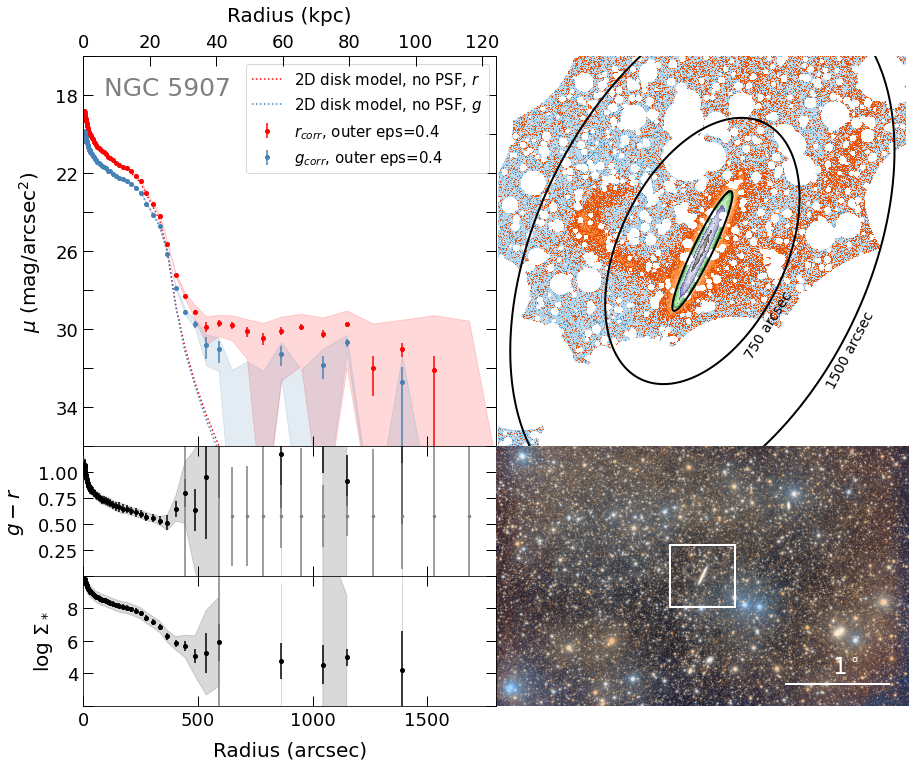

In [115]:
fig = plt.figure(constrained_layout=True)
gs1 = gridspec.GridSpec(6, 6, figure=fig, wspace=0,hspace=0)
#gs1 = gridspec.GridSpec(3,2,wspace=0,hspace=0, height_ratios = [3,1,1])

xmax = 1800

################################################################################
# Surface brightness profiles
##ax0 = plt.subplot(gs1[0])
ax0 = fig.add_subplot(gs1[0:3, 0:3])

ax0.errorbar(rad_r_round*pix_size, SB_r_corr, yerr=SB_err_r_corr, fmt='o', color='r', label="$r_{corr}$, outer eps=0.4", markersize=4)
ax0.errorbar(rad_r_round*pix_size, SB_g_corr, yerr=SB_err_g_corr, fmt='o', color='steelblue', label="$g_{corr}$, outer eps=0.4", markersize=4)
ax0.fill_between(rad_r_round*pix_size, SB_err_r_corr_ps - extinct_r, SB_err_r_corr_ms - extinct_r, alpha=0.15, color="r")
ax0.fill_between(rad_g_round*pix_size, SB_err_g_corr_ps - extinct_g, SB_err_g_corr_ms - extinct_g, alpha=0.15, color="steelblue")

#plt.plot(isophotes_model_round.sma*pix_size, gp.flux_to_mags(isophotes_model_round.intens, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
ax0.plot(isophotes_model_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_noPSF_round.intens, 0.0, zerop_r), "r:", label="2D disk model, no PSF, $r$")

#plt.plot(isophotes_model_g_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_round.intens, 0.0, zerop_g), "--", c="steelblue", lw=4, label="2D model with PSF, $g$")
ax0.plot(isophotes_model_g_noPSF_round.sma*pix_size, gp.flux_to_mags(isophotes_model_g_noPSF_round.intens, 0.0, zerop_g), ":", c="steelblue", label="2D disk model, no PSF, $g$")


ax0.text(xmax/20, 18, f"NGC {gal}", size=25, color="gray")

leg = plt.legend(prop={'size': 15})

ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=20, labelpad=12)
ax0.xaxis.set_tick_params(which='major',size=10,pad=5,right=True, direction="in")

# Secondary x axis for physical length scales
ax00 = ax0.twiny()
ax00.set_xlim(0,kpc_factor*xmax) 
ax00.set_xlabel(r"Radius (kpc)", size=20, labelpad=12)
ax00.xaxis.set_tick_params(which='major',size=10,pad=5,top=True, bottom=False, direction="in")

ax0.set_xlim(0, xmax)
ax0.set_xticklabels([])

ax0.set_ylim(36, 16)
ax0.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax0.set_yticklabels(["", "18", "", "22", "", "26", "", "30", "", "34", "" ])

################################################################################
# g-r colour profiles
##ax1 = plt.subplot(gs1[2])
ax1 = fig.add_subplot(gs1[3, 0:3])

ax1.errorbar(rad_r_round*pix_size, gmr_corr, yerr=gmr_corr_err, fmt='o', label=r"$g-r$", color='k', markersize=4)
ax1.fill_between(rad_r_round*pix_size, gmr_corr + gmr_corr_err_sys, gmr_corr - gmr_corr_err_sys, alpha=0.15, color="k")

ax1.set_ylabel(r"$g-r$", size=20, labelpad=12)
#ax1.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax1.set_ylim(0,1.25)
ax1.set_yticks([0.0 ,0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_yticklabels(["", "0.25", "0.50", "0.75", "1.00", ""])

ax1.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax1.set_xlim(0,xmax)
ax1.set_xticklabels([])

ax1.axvline(x=rad_r[range_index_corr[0]]*pix_size, c="gray")
ax1.axvline(x=rad_r[range_index_corr[1]]*pix_size, c="gray")

ax1.errorbar(rad_r_round[range_index_corr[1]+1:]*pix_size, gmr_round_fixed[range_index_corr[1]+1:], yerr=gmr_round_err[range_index_corr[1]+1:], fmt='o', label=r"$g-r$", color='gray', markersize=2.5)


################################################################################
# Galaxy image
##ax2 = plt.subplot(gs1[1])
ax2 = fig.add_subplot(gs1[0:3, 3:6])

image_r_masked = np.ma.masked_array(image_r_sub, mask>0)

cmap = plt.get_cmap('tab20c')
cmap.set_bad('black',np.nan)

#dud = ax2.imshow(-2.5*np.log10(image_r_masked-r_sky_global) + zerop_r + 5*np.log10(pix_size), 
#                 origin="lower", cmap=cmap, vmin=16, vmax=32, interpolation="nearest")
dud = ax2.imshow(np.log10(image_r_masked+7), origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation="nearest")
##plt.colorbar(dud, ax=ax2)
ax2.axis('off')

for rtemp in [1500, 750, 375]:
    iso = dummy_isophotes_round.get_closest(rtemp/pix_size)
    print(f"Closest isophote to {rtemp} arcsec is {iso.sma*pix_size} arcsec")
    x, y, = iso.sampled_coordinates()
    ax2.plot(x[1:], y[1:], color='k', lw=2)

ax2.text(2270, 1700, "1500 arcsec", size=14, rotation=62)  
ax2.text(2090, 1765, "750 arcsec", size=14, rotation=58)
    
ax2.set_xlim(1550,2450)
ax2.set_ylim(1570,2430)



################################################################################
# False colour image of wider field

ax3 = fig.add_subplot(gs1[3:5, 3:6])
ax3.imshow(false_color, origin="upper")
ax3.axis('off')

ax3.set_xlim(0,3840)
ax3.set_ylim(2650,230)

width = (2450-1550)*0.6678
height = (2430-1570)*0.6678
zoombox = patches.Rectangle((1920-width/2,1440-height/2), width, height, linewidth=2, 
                             edgecolor='white', facecolor="none")
ax3.add_patch(zoombox)

len_bar = 3600/pix_size * 0.6678
ax3.plot([2700,2700+len_bar],[2450,2450], lw=2, c="white")
ax3.text(2650+len_bar/2, 2350, r"1$^\circ$", size=23, c="white")


################################################################################
# Mass density profile
##ax4 = plt.subplot(gs1[4])
ax4 = fig.add_subplot(gs1[4, 0:3])

ax4.errorbar(rad_r_round*pix_size, mass_density_corr_fixed, yerr=mass_density_corr_err, fmt='o', c="k", markersize=4)

ax4.fill_between(rad_r_round*pix_size, mass_density_corr_fixed - mass_density_corr_err_sys, mass_density_corr_fixed + mass_density_corr_err_sys, alpha=0.15, color="k")

ax4.set_ylabel(r"log $\Sigma_*$", size=20, labelpad=12)
ax4.set_xlabel(r"Radius (arcsec)", size=20, labelpad=12)

ax4.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax4.set_xlim(0,xmax)

ax4.axvline(x=rad_r[range_index_corr[1]]*pix_size, c="gray")

ax4.set_ylim(2,10)
ax4.set_yticks([2,4,6,8,10])
ax4.set_yticklabels(["", "4", "6", "8", ""])

################################################################################
for a in [ax0, ax1, ax4, ax00]:
    
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")
    a.tick_params(labelsize=18)

fig.set_size_inches(13,12)
fig.tight_layout()
plt.savefig(f"/home/cgilhuly/Workspace/Profiles/Figures/NGC{gal}_profiles_round2.pdf", dpi=300)
plt.show()

### Showing original profile alongside final (round-ified and scattered light-subtracted)

Closest isophote to 1500 arcsec is 1528.9772612103661 arcsec
Closest isophote to 750 arcsec is 784.6070941802509 arcsec
Closest isophote to 375 arcsec is 366.0250000000002 arcsec
Closest isophote to 1500 arcsec is 1528.9772612103661 arcsec
Closest isophote to 750 arcsec is 784.6070941802509 arcsec
Closest isophote to 375 arcsec is 366.0250000000002 arcsec


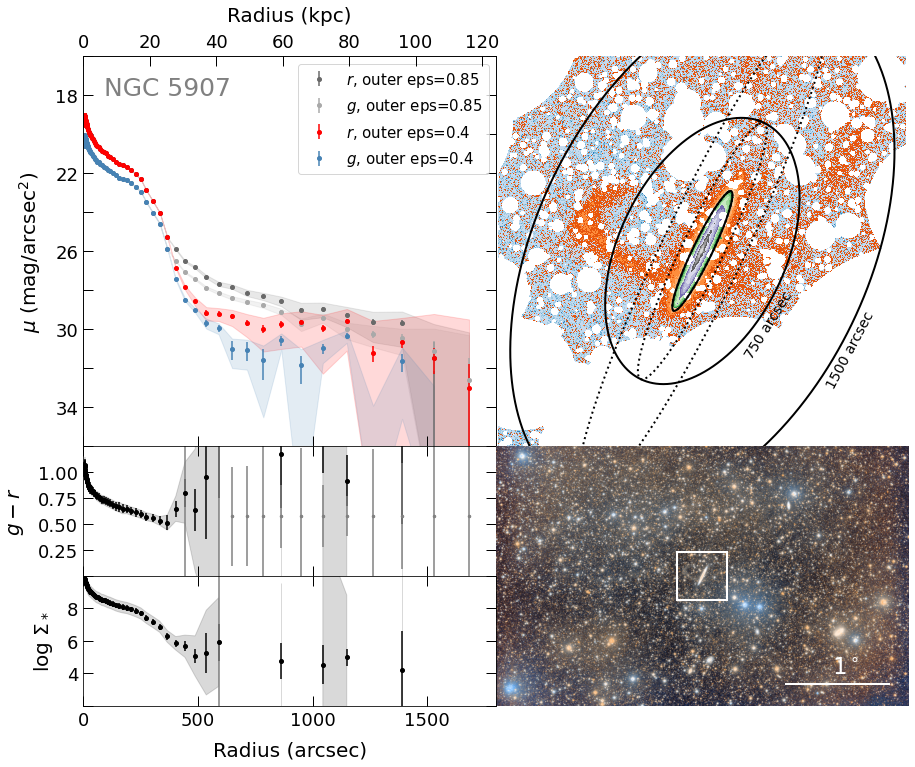

In [117]:
fig = plt.figure(constrained_layout=True)
gs1 = gridspec.GridSpec(6, 6, figure=fig, wspace=0,hspace=0)
#gs1 = gridspec.GridSpec(3,2,wspace=0,hspace=0, height_ratios = [3,1,1])

xmax = 1800

################################################################################
# Surface brightness profiles
##ax0 = plt.subplot(gs1[0])
ax0 = fig.add_subplot(gs1[0:3, 0:3])

ax0.errorbar(rad_r*2.5, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="dimgrey", label="$r$, outer eps=0.85", markersize=4)
ax0.errorbar(rad_g*2.5, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="darkgrey", label="$g$, outer eps=0.85", markersize=4)
ax0.fill_between(rad_r*2.5, err_r_ps - extinct_r, err_r_ms - extinct_r, alpha=0.15, color="dimgrey")
ax0.fill_between(rad_g*2.5, err_g_ps - extinct_g, err_g_ms - extinct_g, alpha=0.15, color="darkgrey")

ax0.errorbar(rad_r_round*2.5, SB_r_round - extinct_r, yerr=SB_err_r_round, fmt='o', c="r", label="$r$, outer eps=0.4", markersize=4)
ax0.errorbar(rad_g_round*2.5, SB_g_round - extinct_g, yerr=SB_err_g_round, fmt='o', c="steelblue", label="$g$, outer eps=0.4", markersize=4)
ax0.fill_between(rad_r_round*2.5, err_r_ps_round - extinct_r, err_r_ms_round - extinct_r, alpha=0.15, color="r")
ax0.fill_between(rad_g_round*2.5, err_g_ps_round - extinct_g, err_g_ms_round - extinct_g, alpha=0.15, color="steelblue")

ax0.text(xmax/20, 18, f"NGC {gal}", size=25, color="gray")

leg = plt.legend(prop={'size': 15})

ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=20, labelpad=12)
ax0.xaxis.set_tick_params(which='major',size=10,pad=5,right=True, direction="in")

# Secondary x axis for physical length scales
ax00 = ax0.twiny()
ax00.set_xlim(0,kpc_factor*xmax) 
ax00.set_xlabel(r"Radius (kpc)", size=20, labelpad=12)
ax00.xaxis.set_tick_params(which='major',size=10,pad=5,top=True, bottom=False, direction="in")

ax0.set_xlim(0, xmax)
ax0.set_xticklabels([])

ax0.set_ylim(36, 16)
ax0.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax0.set_yticklabels(["", "18", "", "22", "", "26", "", "30", "", "34", "" ])

################################################################################
# g-r colour profiles
##ax1 = plt.subplot(gs1[2])
ax1 = fig.add_subplot(gs1[3, 0:3])

ax1.errorbar(rad_r_round*pix_size, gmr_corr, yerr=gmr_corr_err, fmt='o', label=r"$g-r$", color='k', markersize=4)
ax1.fill_between(rad_r_round*pix_size, gmr_corr + gmr_corr_err_sys, gmr_corr - gmr_corr_err_sys, alpha=0.15, color="k")

ax1.set_ylabel(r"$g-r$", size=20, labelpad=12)
#ax1.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax1.set_ylim(0,1.25)
ax1.set_yticks([0.0 ,0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_yticklabels(["", "0.25", "0.50", "0.75", "1.00", ""])

ax1.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax1.set_xlim(0,xmax)
ax1.set_xticklabels([])

ax1.axvline(x=rad_r[range_index_corr[0]]*pix_size, c="gray")
ax1.axvline(x=rad_r[range_index_corr[1]]*pix_size, c="gray")

ax1.errorbar(rad_r_round[range_index_corr[1]+1:]*pix_size, gmr_round_fixed[range_index_corr[1]+1:], yerr=gmr_round_err[range_index_corr[1]+1:], fmt='o', label=r"$g-r$", color='gray', markersize=2.5)


################################################################################
# Galaxy image
##ax2 = plt.subplot(gs1[1])
ax2 = fig.add_subplot(gs1[0:3, 3:6])

image_r_masked = np.ma.masked_array(image_r_sub, mask>0)

cmap = plt.get_cmap('tab20c')
cmap.set_bad('black',np.nan)

#dud = ax2.imshow(-2.5*np.log10(image_r_masked-r_sky_global) + zerop_r + 5*np.log10(pix_size), 
#                 origin="lower", cmap=cmap, vmin=16, vmax=32, interpolation="nearest")
dud = ax2.imshow(np.log10(image_r_masked+7), origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation="nearest")
##plt.colorbar(dud, ax=ax2)
ax2.axis('off')

for rtemp in [1500, 750, 375]:
    iso = dummy_isophotes.get_closest(rtemp/pix_size)
    print(f"Closest isophote to {rtemp} arcsec is {iso.sma*pix_size} arcsec")
    x, y, = iso.sampled_coordinates()
    ax2.plot(x[1:], y[1:], 'k:', lw=2)

for rtemp in [1500, 750, 375]:
    iso = dummy_isophotes_round.get_closest(rtemp/pix_size)
    print(f"Closest isophote to {rtemp} arcsec is {iso.sma*pix_size} arcsec")
    x, y, = iso.sampled_coordinates()
    ax2.plot(x[1:], y[1:], color='k', lw=2)

ax2.text(2270, 1700, "1500 arcsec", size=14, rotation=62)  
ax2.text(2090, 1765, "750 arcsec", size=14, rotation=58)
    
ax2.set_xlim(1550,2450)
ax2.set_ylim(1570,2430)



################################################################################
# False colour image of wider field

ax3 = fig.add_subplot(gs1[3:5, 3:6])
ax3.imshow(false_color, origin="upper")
ax3.axis('off')

ax3.set_xlim(0,3840)
ax3.set_ylim(2650,230)

width = (2350-1650)*0.6678
height = (2335-1665)*0.6678
zoombox = patches.Rectangle((1920-width/2,1440-height/2), width, height, linewidth=2, 
                             edgecolor='white', facecolor="none")
ax3.add_patch(zoombox)

len_bar = 3600/pix_size * 0.6678
ax3.plot([2700,2700+len_bar],[2450,2450], lw=2, c="white")
ax3.text(2650+len_bar/2, 2350, r"1$^\circ$", size=23, c="white")


################################################################################
# Mass density profile
##ax4 = plt.subplot(gs1[4])
ax4 = fig.add_subplot(gs1[4, 0:3])

ax4.errorbar(rad_r_round*pix_size, mass_density_corr_fixed, yerr=mass_density_corr_err, fmt='o', c="k", markersize=4)

ax4.fill_between(rad_r_round*pix_size, mass_density_corr_fixed - mass_density_corr_err_sys, mass_density_corr_fixed + mass_density_corr_err_sys, alpha=0.15, color="k")

ax4.set_ylabel(r"log $\Sigma_*$", size=20, labelpad=12)
ax4.set_xlabel(r"Radius (arcsec)", size=20, labelpad=12)

ax4.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax4.set_xlim(0,xmax)

ax4.axvline(x=rad_r[range_index_corr[1]]*pix_size, c="gray")

ax4.set_ylim(2,10)
ax4.set_yticks([2,4,6,8,10])
ax4.set_yticklabels(["", "4", "6", "8", ""])

################################################################################
for a in [ax0, ax1, ax4, ax00]:
    
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")
    a.tick_params(labelsize=18)

fig.set_size_inches(13,12)
fig.tight_layout()
plt.savefig(f"/home/cgilhuly/Workspace/Profiles/Figures/NGC{gal}_profiles_comparison2.pdf", dpi=300)
plt.show()